# V-JEPA2-AC Energy Landscape Analysis

## Analyzing the Effect of LoRA Fine-Tuning on World Model Action Prediction

**Research Question:** Does LoRA fine-tuning of V-JEPA2-AC on additional DROID data improve the world model's action prediction capabilities?

**Methodology:**
- Compare energy landscapes between baseline (pre-trained) and fine-tuned models
- Quantify improvements using metrics: offset error, rank of true action, landscape sharpness
- Visualize energy landscapes as 2D heatmaps

**Based on:** Official V-JEPA2 energy landscape example notebook

---

## Cell 0: Environment Setup

In [1]:
# Install dependencies
!pip install -q torch torchvision
!pip install -q timm einops scipy
!pip install -q matplotlib seaborn pandas
!pip install -q peft  # peft for LoRA fintune

# Clone vjepa2 repo to use their transform and utils
!git clone https://github.com/facebookresearch/vjepa2.git
%cd vjepa2
!pip install -q -e .
%cd ..

Cloning into 'vjepa2'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 310 (delta 83), reused 45 (delta 45), pack-reused 174 (from 2)
Receiving objects: 100% (310/310), 580.39 KiB | 5.69 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/vjepa2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 141.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 8.2 MB/s eta 0

In [2]:
# Verify GPU, we run on:
# PyTorch version: 2.9.0+cu126
# CUDA available: True
# GPU: NVIDIA A100-SXM4-40GB
# GPU Memory: 42.5 GB
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device("cuda")
else:
    print("WARNING: No GPU available, using CPU (will be slow)")
    device = torch.device("cpu")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB


## Cell 1: Imports and Configuration

In [3]:
import sys
import os

# Add vjepa2 repo paths
VJEPA2_PATH = "vjepa2"
VJEPA2_NOTEBOOKS_PATH = os.path.join(VJEPA2_PATH, "notebooks")

for path in [VJEPA2_PATH, VJEPA2_NOTEBOOKS_PATH]:
    if path not in sys.path:
        sys.path.insert(0, path)

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Any
from tqdm.notebook import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F

# PEFT for LoRA
from peft import LoraConfig, get_peft_model, PeftModel

# V-JEPA2 utilities
from app.vjepa_droid.transforms import make_transforms

# Load mpc_utils from notebooks/utils/
import importlib.util
mpc_utils_path = os.path.join(VJEPA2_PATH, "notebooks", "utils", "mpc_utils.py")
spec = importlib.util.spec_from_file_location("mpc_utils", mpc_utils_path)
mpc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mpc_utils)

compute_new_pose = mpc_utils.compute_new_pose
poses_to_diff = mpc_utils.poses_to_diff

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All imports successful!")
print(f"  compute_new_pose: {compute_new_pose}")
print(f"  poses_to_diff: {poses_to_diff}")

All imports successful!
  compute_new_pose: <function compute_new_pose at 0x788270b65a80>
  poses_to_diff: <function poses_to_diff at 0x788270b660c0>


In [4]:
@dataclass
class EnergyLandscapeConfig:
    """Configuration for energy landscape analysis."""

    # Image/model parameters
    crop_size: int = 256

    # Action grid parameters which is 2D sweep over x, y
    grid_size: float = 0.15  # +/- 7.5cm range (same as official)
    grid_resolution: int = 25  # 25x25 = 625 points (higher res than official 5x5)

    # Fixed action components
    fixed_delta_z: float = 0.0
    fixed_delta_roll: float = 0.0
    fixed_delta_pitch: float = 0.0
    fixed_delta_yaw: float = 0.0
    fixed_delta_gripper: float = 0.0

    # Analysis parameters
    num_samples: int = 30  # Number of trajectory samples to analyze
    action_repeat: int = 1  # How many times to repeat action/Roll out steps
    normalize_reps: bool = True  # Layer norm on representations

    # Data source
    use_droid: bool = False  # Set to False to use official franka_example_traj.npz

    # Paths
    output_dir: str = "./energy_analysis_results"

    # Google Drive paths for weight caching
    drive_cache_dir: str = "/content/drive/MyDrive/vjepa2_weights"


# Create configuration
config = EnergyLandscapeConfig()

# Create output directory
Path(config.output_dir).mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Grid: {config.grid_resolution}x{config.grid_resolution} = {config.grid_resolution**2} points")
print(f"  Action range: ±{config.grid_size*100:.1f} cm")
print(f"  Data source: {'DROID' if config.use_droid else 'Official example trajectory'}")

# Install TensorFlow for DROID loading
!pip install -q tensorflow tensorflow_datasets
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

Configuration:
  Grid: 25x25 = 625 points
  Action range: ±15.0 cm
  Data source: Official example trajectory
TensorFlow version: 2.19.0


## Cell 2: Load V-JEPA2-AC Model (with Drive Caching)

In [5]:
# Mount Google Drive for persistent weight storage
from google.colab import drive
drive.mount('/content/drive')

# Create cache directory
os.makedirs(config.drive_cache_dir, exist_ok=True)

ENCODER_CACHE_PATH = f"{config.drive_cache_dir}/vjepa2_ac_encoder.pt"
PREDICTOR_CACHE_PATH = f"{config.drive_cache_dir}/vjepa2_ac_predictor.pt"

print(f"Cache directory: {config.drive_cache_dir}")

Mounted at /content/drive
Cache directory: /content/drive/MyDrive/vjepa2_weights


In [6]:
def load_vjepa2_ac_base(device: torch.device) -> Tuple[nn.Module, nn.Module]:
    """
    Load V-JEPA2-AC model with Google Drive caching.

    Returns:
        encoder: V-JEPA2 ViT-g encoder (~1B params)
        predictor: V-JEPA2-AC predictor (~305M params)
    """
    # Check if cached weights exist
    if os.path.exists(ENCODER_CACHE_PATH) and os.path.exists(PREDICTOR_CACHE_PATH):
        print("Loading V-JEPA2-AC from Google Drive cache...")

        # Load architecture without pretrained weights
        encoder, predictor = torch.hub.load(
            'facebookresearch/vjepa2',
            'vjepa2_ac_vit_giant',
            pretrained=False
        )

        # Load cached state dicts
        encoder.load_state_dict(torch.load(ENCODER_CACHE_PATH, map_location='cpu'))
        predictor.load_state_dict(torch.load(PREDICTOR_CACHE_PATH, map_location='cpu'))
        print("Loaded from cache successfully!")

    else:
        print("Downloading V-JEPA2-AC from torch.hub...")
        encoder, predictor = torch.hub.load(
            'facebookresearch/vjepa2',
            'vjepa2_ac_vit_giant',
            pretrained=True
        )
        print(f"Saving weights to Google Drive...")
        torch.save(encoder.state_dict(), ENCODER_CACHE_PATH)
        torch.save(predictor.state_dict(), PREDICTOR_CACHE_PATH)
        print("Weights cached for future sessions!")

    # Move to device and set to eval mode
    encoder = encoder.to(device).eval()
    predictor = predictor.to(device).eval()

    # Freeze encoder
    for param in encoder.parameters():
        param.requires_grad = False

    # Print model info
    encoder_params = sum(p.numel() for p in encoder.parameters())
    predictor_params = sum(p.numel() for p in predictor.parameters())

    print(f"\nModel loaded successfully!")
    print(f"  Encoder: {encoder_params / 1e9:.2f}B params")
    print(f"  Predictor: {predictor_params / 1e6:.2f}M params")

    return encoder, predictor


# Load models
encoder, predictor_baseline = load_vjepa2_ac_base(device)

Loading V-JEPA2-AC from Google Drive cache...
Downloading: "https://github.com/facebookresearch/vjepa2/zipball/main" to /root/.cache/torch/hub/main.zip
Loaded from cache successfully!

Model loaded successfully!
  Encoder: 1.01B params
  Predictor: 305.22M params


In [10]:
# Initialize transform and compute tokens_per_frame (following official notebook)
tokens_per_frame = int((config.crop_size // encoder.patch_size) ** 2)
print(f"Tokens per frame: {tokens_per_frame}")
print(f"  (crop_size={config.crop_size}, patch_size={encoder.patch_size})")

# Create transform (same as official notebook)
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=config.crop_size,
)

print("Transform initialized!")

Tokens per frame: 256
  (crop_size=256, patch_size=16)
Transform initialized!


## Cell 3: Load Trajectory Data

**Option A:** Official `franka_example_traj.npz` for baseline testing against official VJEPA2 implementation

**Option B:** DROID dataset


In [8]:
# OPTION A: Load official example trajectory
def load_official_example_trajectory():
    """
    Load the official franka_example_traj.npz from vjepa2 repo.

    Returns:
        np_clips: [1, T, H, W, C] video frames
        np_states: [1, T, 7] robot states
        np_actions: [1, 1, 7] ground truth action
    """
    traj_path = "vjepa2/notebooks/franka_example_traj.npz"

    if not os.path.exists(traj_path):
        raise FileNotFoundError(
            f"Trajectory file not found at {traj_path}. "
            f"Make sure vjepa2 repo is cloned correctly."
        )

    trajectory = np.load(traj_path)
    np_clips = trajectory["observations"]  # [1, T, H, W, C]
    np_states = trajectory["states"]  # [1, T, 7]

    # Compute ground truth action (difference between first two states)
    np_actions = np.expand_dims(
        poses_to_diff(np_states[0, 0], np_states[0, 1]),
        axis=(0, 1)
    )  # [1, 1, 7]

    print(f"Loaded official example trajectory:")
    print(f"  Clips shape: {np_clips.shape}")
    print(f"  States shape: {np_states.shape}")
    print(f"  Actions shape: {np_actions.shape}")
    print(f"  Ground truth action (x,y,z): ({np_actions[0, 0, 0]:.4f}, {np_actions[0, 0, 1]:.4f}, {np_actions[0, 0, 2]:.4f})")

    return np_clips, np_states, np_actions

# OPTION B: Load from DROID dataset

def load_droid_trajectories(num_samples: int = 30, frame_gap: int = 4):
    """
    Load trajectories from DROID dataset in RLDS format.

    Args:
        num_samples: Number of trajectory samples to extract
        frame_gap: Number of frames between current and goal

    Returns:
        List of (np_clips, np_states, np_actions) tuples matching official format
    """
    import tensorflow as tf
    import tensorflow_datasets as tfds

    # Disable GPU for TensorFlow, use PyTorch for model
    tf.config.set_visible_devices([], 'GPU')
    dataset_name = "droid_100"

    print(f"Loading {dataset_name} from Google Cloud Storage...")
    print("(This may take a few minutes on first load)")

    # Load directly from GCS
    ds = tfds.load(
        dataset_name,
        data_dir="gs://gresearch/robotics",
        split="train"
    )

    trajectories = []
    episodes_processed = 0

    print(f"Extracting {num_samples} samples...")

    for episode in ds:
        if len(trajectories) >= num_samples:
            break

        # Getting steps from episdes and skipping short ones
        steps = list(episode["steps"])
        num_steps = len(steps)
        if num_steps < frame_gap + 2:
            continue

        # Extract frames, states, actions from this episode
        frames = []
        states = []

        for step in steps:
            obs = step["observation"]

            # Get image (exterior_image_1_left is the main camera)
            image = obs["exterior_image_1_left"].numpy()  # [180, 320, 3] uint8

            # Get state: cartesian_position [6] + gripper_position [1] = [7]
            cartesian = obs["cartesian_position"].numpy()  # [6]
            gripper = obs["gripper_position"].numpy()  # [1]
            state = np.concatenate([cartesian, gripper])  # [7]

            frames.append(image)
            states.append(state)

        frames = np.array(frames)  # [T, H, W, C]
        states = np.array(states)  # [T, 7]

        # Resize frames to 256x256 (to match official example)
        frames_resized = []
        for frame in frames:
            # Simple resize using numpy/cv2
            import cv2
            frame_resized = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LINEAR)
            frames_resized.append(frame_resized)
        frames_resized = np.array(frames_resized)  # [T, 256, 256, 3]

        # Sample a starting point for this trajectory
        # We need at least frame_gap+1 frames
        max_start = num_steps - frame_gap - 1
        if max_start <= 0:
            continue

        # Take a sample from middle of trajectory (more interesting motion)
        start_idx = max_start // 2
        end_idx = start_idx + frame_gap + 1

        # Extract clip (current frame + goal frame)
        # Format: [1, T, H, W, C] where T=2 (current and goal)
        current_frame = frames_resized[start_idx]
        goal_frame = frames_resized[end_idx]
        np_clips = np.stack([current_frame, goal_frame], axis=0)[np.newaxis, ...]  # [1, 2, 256, 256, 3]

        # Extract states
        np_states = states[start_idx:end_idx+1][np.newaxis, ...]  # [1, T, 7]

        # Compute ground truth action using poses_to_diff
        np_actions = np.expand_dims(
            poses_to_diff(states[start_idx], states[start_idx + frame_gap]),
            axis=(0, 1)
        )

        trajectories.append((np_clips, np_states, np_actions))
        episodes_processed += 1

        if episodes_processed % 10 == 0:
            print(f"  Processed {episodes_processed} episodes, extracted {len(trajectories)} samples")

    print(f"\nLoaded {len(trajectories)} trajectory samples from DROID")

    if len(trajectories) > 0:
        print(f"Sample format:")
        print(f"  clips shape: {trajectories[0][0].shape}")
        print(f"  states shape: {trajectories[0][1].shape}")
        print(f"  actions shape: {trajectories[0][2].shape}")

    return trajectories

In [9]:
config.use_droid = True
# Load data based on config
if config.use_droid:
    trajectories = load_droid_trajectories(
        num_samples=config.num_samples,
        frame_gap=64,
    )
else:
    np_clips, np_states, np_actions = load_official_example_trajectory()
    trajectories = [(np_clips, np_states, np_actions)]

print(f"\nLoaded {len(trajectories)} trajectories")

Loading droid_100 from Google Cloud Storage...
(This may take a few minutes on first load)
[INFO    ][2025-12-05 15:21:38][absl                ][read_from_directory      ] Load dataset info from gs://gresearch/robotics/droid_100/1.0.0
[INFO    ][2025-12-05 15:21:38][absl                ][_read_files              ] Creating a tf.data.Dataset reading 31 files located in folders: gs://gresearch/robotics/droid_100/1.0.0.
[INFO    ][2025-12-05 15:21:38][absl                ][as_dataset               ] Constructing tf.data.Dataset r2d2_faceblur for split train, from gs://gresearch/robotics/droid_100/1.0.0
Extracting 30 samples...
  Processed 10 episodes, extracted 10 samples
  Processed 20 episodes, extracted 20 samples
  Processed 30 episodes, extracted 30 samples

Loaded 30 trajectory samples from DROID
Sample format:
  clips shape: (1, 2, 256, 256, 3)
  states shape: (1, 66, 7)
  actions shape: (1, 1, 7)

Loaded 30 trajectories


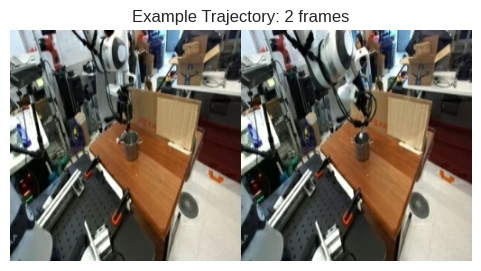


Ground truth action (x, y, z): (-0.0827, -0.1000, 0.0629)


In [10]:
# Visualize loaded trajectory
np_clips_viz, np_states_viz, np_actions_viz = trajectories[0]

T = np_clips_viz.shape[1]
plt.figure(figsize=(20, 3))
plt.imshow(np.transpose(np_clips_viz[0], (1, 0, 2, 3)).reshape(256, 256 * T, 3))
plt.title(f"Example Trajectory: {T} frames")
plt.axis('off')
plt.show()

print(f"\nGround truth action (x, y, z): ({np_actions_viz[0, 0, 0]:.4f}, {np_actions_viz[0, 0, 1]:.4f}, {np_actions_viz[0, 0, 2]:.4f})")

## Cell 4: Energy Computation Functions (Following Official Notebook)

In [11]:
def forward_target(clips: torch.Tensor, encoder: nn.Module, normalize_reps: bool = True) -> torch.Tensor:
    """
    Encode video clips using V-JEPA2 encoder.
    (Following official notebook exactly)

    Args:
        clips: [B, C, T, H, W] video tensor
        encoder: V-JEPA2 encoder
        normalize_reps: Whether to apply layer norm

    Returns:
        h: [B, T*tokens_per_frame, D] encoded representations
    """
    B, C, T, H, W = clips.size()

    # Reshape: [B, C, T, H, W] -> [B*T, C, 2, H, W] (duplicate each frame)
    c = clips.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)

    # Encode
    h = encoder(c)

    # Reshape back: [B*T, N, D] -> [B, T*N, D]
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)

    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))

    return h


def step_predictor(
    predictor: nn.Module,
    z: torch.Tensor,
    a: torch.Tensor,
    s: torch.Tensor,
    tokens_per_frame: int,
    normalize_reps: bool = True
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Single prediction step with the predictor.

    Args:
        predictor: V-JEPA2-AC predictor
        z: Current latent state [B, N, D]
        a: Action [B, T, 7]
        s: Robot state [B, T, 7]
        tokens_per_frame: Number of tokens per frame
        normalize_reps: Whether to apply layer norm

    Returns:
        z_new: Predicted next latent [B, tokens_per_frame, D]
        s_new: Predicted next state [B, 1, 7]
    """
    z_new = predictor(z, a, s)[:, -tokens_per_frame:]

    if normalize_reps:
        z_new = F.layer_norm(z_new, (z_new.size(-1),))

    s_new = compute_new_pose(s[:, -1:], a[:, -1:])

    return z_new, s_new


def compute_energy(z_pred: torch.Tensor, z_goal: torch.Tensor, tokens_per_frame: int) -> torch.Tensor:
    """
    Compute energy (L1 distance) between predicted and goal representations.

    Args:
        z_pred: Predicted representation [B, N, D]
        z_goal: Goal representation [B, N, D]
        tokens_per_frame: Number of tokens per frame

    Returns:
        energy: [B] energy values
    """
    # Use only the last frame's tokens
    z_pred = z_pred[:, -tokens_per_frame:]
    z_goal = z_goal[:, -tokens_per_frame:]

    # L1 distance, averaged over tokens and dimensions
    energy = torch.abs(z_pred - z_goal).mean(dim=[1, 2])

    return energy

In [12]:
def create_2d_action_grid(
    grid_size: float,
    grid_resolution: int,
    fixed_z: float = 0.0,
    device: torch.device = torch.device('cpu')
) -> Tuple[np.ndarray, np.ndarray, torch.Tensor]:
    """
    Create 2D grid of actions varying (delta_x, delta_y).

    Args:
        grid_size: Range for actions (±grid_size)
        grid_resolution: Number of points per dimension
        fixed_z: Fixed value for delta_z
        device: Torch device

    Returns:
        delta_x_values: 1D array of x values
        delta_y_values: 1D array of y values
        action_grid: [grid_res*grid_res, 1, 7] tensor of actions
    """
    delta_x_values = np.linspace(-grid_size, grid_size, grid_resolution)
    delta_y_values = np.linspace(-grid_size, grid_size, grid_resolution)

    action_samples = []
    for dx in delta_x_values:
        for dy in delta_y_values:
            action = torch.tensor(
                [dx, dy, fixed_z, 0, 0, 0, 0],
                device=device,
                dtype=torch.float32
            )
            action_samples.append(action)

    # Stack and add time dimension: [num_actions, 7] -> [num_actions, 1, 7]
    action_grid = torch.stack(action_samples, dim=0).unsqueeze(1)

    return delta_x_values, delta_y_values, action_grid

In [13]:
# Create action grid
delta_x_values, delta_y_values, action_grid = create_2d_action_grid(
    grid_size=config.grid_size,
    grid_resolution=config.grid_resolution,
    device=device
)

print(f"Action grid created:")
print(f"  Shape: {action_grid.shape}")
print(f"  X range: [{delta_x_values[0]:.3f}, {delta_x_values[-1]:.3f}]")
print(f"  Y range: [{delta_y_values[0]:.3f}, {delta_y_values[-1]:.3f}]")
print(f"  Total actions: {len(action_grid)}")

Action grid created:
  Shape: torch.Size([625, 1, 7])
  X range: [-0.150, 0.150]
  Y range: [-0.150, 0.150]
  Total actions: 625


In [14]:
def compute_energy_landscape(
    encoder: nn.Module,
    predictor: nn.Module,
    np_clips: np.ndarray,
    np_states: np.ndarray,
    action_grid: torch.Tensor,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray,
    tokens_per_frame: int,
    transform,
    config: EnergyLandscapeConfig,
    device: torch.device,
    batch_size: int = 64
) -> np.ndarray:
    """
    Compute full energy landscape for a trajectory.

    Args:
        encoder: V-JEPA2 encoder
        predictor: V-JEPA2-AC predictor
        np_clips: [1, T, H, W, C] video frames
        np_states: [1, T, 7] robot states
        action_grid: [num_actions, 1, 7] grid of actions
        delta_x_values: X axis values
        delta_y_values: Y axis values
        tokens_per_frame: Tokens per frame
        transform: Image transform
        config: Configuration
        device: Torch device
        batch_size: Batch size for inference

    Returns:
        energy_landscape: [grid_res, grid_res] 2D energy array
    """
    num_actions = action_grid.shape[0]
    grid_res = config.grid_resolution

    # Transform clips to tensor
    clips = transform(np_clips[0]).unsqueeze(0).to(device)  # [1, C, T, H, W]
    states = torch.tensor(np_states, device=device, dtype=torch.float32)  # [1, T, 7]

    with torch.no_grad():
        # Encode all frames
        h = forward_target(clips, encoder, normalize_reps=config.normalize_reps)

        # Get context (first frame) and goal (last frame)
        z_context = h[:, :tokens_per_frame]  # [1, tokens_per_frame, D]
        z_goal = h[:, -tokens_per_frame:]    # [1, tokens_per_frame, D]
        s_context = states[:, :1]             # [1, 1, 7]

        # Compute energy for each action in batches
        all_energies = []

        for i in range(0, num_actions, batch_size):
            batch_actions = action_grid[i:i+batch_size]  # [B, 1, 7]
            B = batch_actions.shape[0]

            # Expand context for batch
            z_batch = z_context.expand(B, -1, -1)  # [B, tokens_per_frame, D]
            s_batch = s_context.expand(B, -1, -1)  # [B, 1, 7]
            z_goal_batch = z_goal.expand(B, -1, -1)  # [B, tokens_per_frame, D]

            # Rollout predictor
            z_hat = z_batch
            s_hat = s_batch
            a_hat = batch_actions

            for _ in range(config.action_repeat):
                z_new, s_new = step_predictor(
                    predictor, z_hat, a_hat, s_hat,
                    tokens_per_frame, config.normalize_reps
                )
                z_hat = torch.cat([z_hat, z_new], dim=1)
                s_hat = torch.cat([s_hat, s_new], dim=1)
                a_hat = torch.cat([a_hat, batch_actions], dim=1)

            # Compute energy
            energy = compute_energy(z_hat, z_goal_batch, tokens_per_frame)
            all_energies.append(energy.cpu().numpy())

        # Concatenate and reshape to grid
        energies = np.concatenate(all_energies)
        energy_landscape = energies.reshape(grid_res, grid_res)

    return energy_landscape

In [15]:
# Test energy landscape computation on first trajectory
print("Testing energy landscape computation...")

np_clips_test, np_states_test, np_actions_test = trajectories[0]

energy_landscape_test = compute_energy_landscape(
    encoder=encoder,
    predictor=predictor_baseline,
    np_clips=np_clips_test,
    np_states=np_states_test,
    action_grid=action_grid,
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    tokens_per_frame=tokens_per_frame,
    transform=transform,
    config=config,
    device=device
)

print(f"\nEnergy landscape computed!")
print(f"  Shape: {energy_landscape_test.shape}")
print(f"  Min: {energy_landscape_test.min():.4f}")
print(f"  Max: {energy_landscape_test.max():.4f}")
print(f"  Mean: {energy_landscape_test.mean():.4f}")

Testing energy landscape computation...

Energy landscape computed!
  Shape: (25, 25)
  Min: 0.3933
  Max: 0.4148
  Mean: 0.4019


## Cell 5: Metric Computation

In [19]:
def compute_metrics(
    energy_landscape: np.ndarray,
    true_action: np.ndarray,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray
) -> Dict[str, float]:
    """
    Compute metrics from energy landscape.

    Args:
        energy_landscape: [grid_res, grid_res] energy values
        true_action: [7] ground truth action
        delta_x_values: X axis values
        delta_y_values: Y axis values

    Returns:
        Dictionary of metrics
    """
    grid_res = energy_landscape.shape[0]
    energies_flat = energy_landscape.flatten()

    # Ground truth action location
    gt_x, gt_y = true_action[0], true_action[1]

    # Find closest grid point to true action
    gt_i = np.argmin(np.abs(delta_x_values - gt_x))
    gt_j = np.argmin(np.abs(delta_y_values - gt_y))

    # Check if true action is within grid range
    in_range = (
        delta_x_values[0] <= gt_x <= delta_x_values[-1] and
        delta_y_values[0] <= gt_y <= delta_y_values[-1]
    )

    # Energy at true action (approximated by nearest grid point)
    energy_at_true = energy_landscape[gt_i, gt_j]

    # Minimum energy and its location
    min_energy = energy_landscape.min()
    min_idx = np.unravel_index(energy_landscape.argmin(), energy_landscape.shape)
    min_x = delta_x_values[min_idx[0]]
    min_y = delta_y_values[min_idx[1]]

    # Offset error (Euclidean distance)
    offset_error = np.sqrt((min_x - gt_x)**2 + (min_y - gt_y)**2)

    # Rank of true action
    gt_flat_idx = gt_i * grid_res + gt_j
    sorted_indices = np.argsort(energies_flat)
    rank = np.where(sorted_indices == gt_flat_idx)[0][0] + 1  # 1-indexed

    # Landscape sharpness
    landscape_std = energy_landscape.std()
    landscape_range = energy_landscape.max() - energy_landscape.min()

    # relative landscape sharpness
    landscape_sharpness = landscape_range / (energy_landscape.mean() + 1e-10)

    metrics = {
        'gt_in_range': in_range,
        'gt_x': gt_x,
        'gt_y': gt_y,
        'energy_at_true': energy_at_true,
        'min_energy': min_energy,
        'min_x': min_x,
        'min_y': min_y,
        'offset_error': offset_error,
        'true_action_rank': rank,
        'landscape_std': landscape_std,
        'landscape_range': landscape_range,
        'landscape_sharpness': landscape_sharpness,
        'energy_gap': energy_at_true - min_energy,
    }

    return metrics

In [20]:
# Test metrics computation
test_metrics = compute_metrics(
    energy_landscape_test,
    np_actions_test[0, 0],
    delta_x_values,
    delta_y_values
)

print("Test metrics:")
for name, value in test_metrics.items():
    if isinstance(value, bool):
        print(f"  {name}: {value}")
    else:
        print(f"  {name}: {value:.4f}")

Test metrics:
  gt_in_range: 1.0000
  gt_x: -0.0827
  gt_y: -0.1000
  energy_at_true: 0.4090
  min_energy: 0.3933
  min_x: -0.0125
  min_y: 0.0375
  offset_error: 0.1544
  true_action_rank: 549.0000
  landscape_std: 0.0052
  landscape_range: 0.0215
  landscape_sharpness: 0.0536
  energy_gap: 0.0157


## Cell 6: Visualization Functions

In [21]:
def plot_energy_heatmap(
    energy_landscape: np.ndarray,
    true_action: np.ndarray,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray,
    title: str = "Energy Landscape",
    ax: Optional[plt.Axes] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None
) -> plt.Axes:
    """
    Plot 2D energy landscape heatmap.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    # Grid bounds
    x_min, x_max = delta_x_values[0], delta_x_values[-1]
    y_min, y_max = delta_y_values[0], delta_y_values[-1]

    # Plot heatmap
    im = ax.imshow(
        energy_landscape.T,  # Transpose for correct orientation
        extent=[x_min, x_max, y_min, y_max],
        origin='lower',
        aspect='equal',  # Changed from 'auto'
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    plt.colorbar(im, ax=ax, label='Energy')

    # Mark true action
    gt_x, gt_y = true_action[0], true_action[1]
    gt_in_range = (x_min <= gt_x <= x_max) and (y_min <= gt_y <= y_max)

    if gt_in_range:
        ax.scatter(gt_x, gt_y, marker='*', s=300, c='red',
                   edgecolors='white', linewidths=2, label='True Action', zorder=5)
    else:
        # Clip marker to edge and show as semi-transparent
        clipped_x = np.clip(gt_x, x_min, x_max)
        clipped_y = np.clip(gt_y, y_min, y_max)
        ax.scatter(clipped_x, clipped_y, marker='*', s=300, c='red',
                   edgecolors='white', linewidths=2, alpha=0.5,
                   label=f'True Action (OOB)', zorder=5)

    # Mark minimum energy
    min_idx = np.unravel_index(energy_landscape.argmin(), energy_landscape.shape)
    min_x = delta_x_values[min_idx[0]]
    min_y = delta_y_values[min_idx[1]]
    ax.scatter(min_x, min_y, marker='x', s=200, c='white',
               linewidths=3, label='Min Energy', zorder=5)

    # Force axis limits to grid bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel(r'$\Delta_x$ (m)', fontsize=12)
    ax.set_ylabel(r'$\Delta_y$ (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right')

    return ax


def plot_comparison(
    energy_baseline: np.ndarray,
    energy_finetuned: np.ndarray,
    true_action: np.ndarray,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray,
    sample_id: int = 0,
    save_path: Optional[str] = None
):
    """
    Plot side-by-side comparison of baseline and fine-tuned.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Common color scale
    vmin = min(energy_baseline.min(), energy_finetuned.min())
    vmax = max(energy_baseline.max(), energy_finetuned.max())

    gt_x, gt_y = true_action[0], true_action[1]
    x_min, x_max = delta_x_values[0], delta_x_values[-1]
    y_min, y_max = delta_y_values[0], delta_y_values[-1]
    gt_in_range = (x_min <= gt_x <= x_max) and (y_min <= gt_y <= y_max)

    plot_energy_heatmap(
        energy_baseline, true_action, delta_x_values, delta_y_values,
        title=f"Baseline - Sample {sample_id}",
        ax=axes[0], vmin=vmin, vmax=vmax
    )

    plot_energy_heatmap(
        energy_finetuned, true_action, delta_x_values, delta_y_values,
        title=f"LoRA Fine-tuned - Sample {sample_id}",
        ax=axes[1], vmin=vmin, vmax=vmax
    )

    # Add GT info to suptitle
    gt_status = "V" if gt_in_range else f"OOB"
    plt.suptitle(f"Sample {sample_id} — GT: ($\\Delta_x$={gt_x:.3f}, $\\Delta_y$={gt_y:.3f}) {gt_status}",
                 fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")

    plt.show()

Visualizing baseline energy landscape...


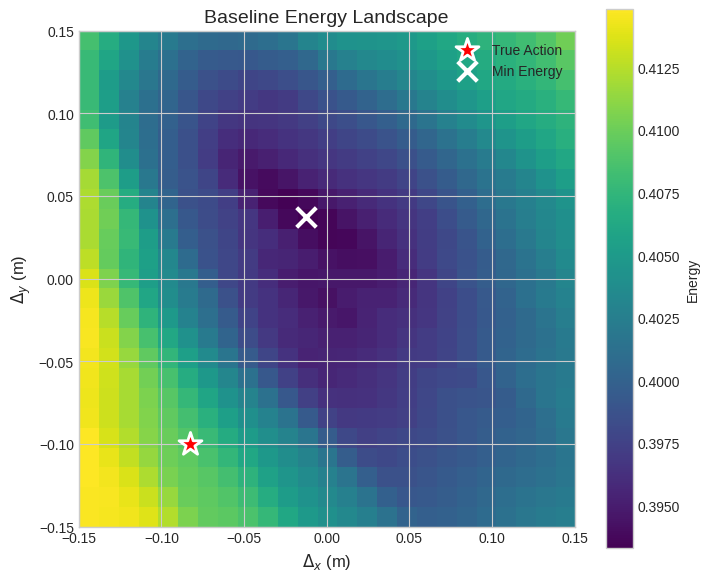


Ground truth: (-0.0827, -0.1000)
Predicted min: (-0.0125, 0.0375)
Offset error: 0.1544 m


In [22]:
# Visualize test energy landscape
print("Visualizing baseline energy landscape...")

plot_energy_heatmap(
    energy_landscape_test,
    np_actions_test[0, 0],
    delta_x_values,
    delta_y_values,
    title="Baseline Energy Landscape"
)
plt.savefig(f"{config.output_dir}/baseline_test.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGround truth: ({np_actions_test[0, 0, 0]:.4f}, {np_actions_test[0, 0, 1]:.4f})")
print(f"Predicted min: ({test_metrics['min_x']:.4f}, {test_metrics['min_y']:.4f})")
print(f"Offset error: {test_metrics['offset_error']:.4f} m")

## Cell 7: Run Baseline Analysis on All Trajectories

In [62]:
def run_full_analysis(
    encoder: nn.Module,
    predictor: nn.Module,
    trajectories: List[Tuple],
    action_grid: torch.Tensor,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray,
    tokens_per_frame: int,
    transform,
    config: EnergyLandscapeConfig,
    device: torch.device,
    model_name: str = "model"
) -> Tuple[List[np.ndarray], pd.DataFrame]:
    """
    Run energy landscape analysis on all trajectories.

    Returns:
        landscapes: List of 2D energy arrays
        metrics_df: DataFrame with all metrics
    """
    print(f"\n{'='*60}")
    print(f"Running analysis: {model_name}")
    print(f"{'='*60}")

    landscapes = []
    all_metrics = []

    for i, (np_clips, np_states, np_actions) in enumerate(tqdm(trajectories, desc=model_name)):
        # Compute energy landscape
        landscape = compute_energy_landscape(
            encoder=encoder,
            predictor=predictor,
            np_clips=np_clips,
            np_states=np_states,
            action_grid=action_grid,
            delta_x_values=delta_x_values,
            delta_y_values=delta_y_values,
            tokens_per_frame=tokens_per_frame,
            transform=transform,
            config=config,
            device=device
        )

        # Compute metrics
        metrics = compute_metrics(
            landscape,
            np_actions[0, 0],
            delta_x_values,
            delta_y_values
        )
        metrics['sample_id'] = i
        metrics['model'] = model_name

        landscapes.append(landscape)
        all_metrics.append(metrics)

    # Create DataFrame
    metrics_df = pd.DataFrame(all_metrics)

    # Print summary
    print(f"\n{model_name} Summary:")
    print(f"  Mean offset error: {metrics_df['offset_error'].mean():.4f} ± {metrics_df['offset_error'].std():.4f} m")
    print(f"  Mean rank: {metrics_df['true_action_rank'].mean():.1f}")

    return landscapes, metrics_df

In [66]:
# Run baseline analysis
baseline_landscapes, baseline_metrics = run_full_analysis(
    encoder=encoder,
    predictor=predictor_baseline,
    trajectories=trajectories,
    action_grid=action_grid,
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    tokens_per_frame=tokens_per_frame,
    transform=transform,
    config=config,
    device=device,
    model_name="baseline"
)

# Save results
baseline_metrics.to_csv(f"{config.output_dir}/baseline_metrics.csv", index=False)
np.save(f"{config.output_dir}/baseline_landscapes.npy", np.array(baseline_landscapes))
print(f"\nBaseline results saved to {config.output_dir}/")


Running analysis: baseline


baseline:   0%|          | 0/30 [00:00<?, ?it/s]


baseline Summary:
  Mean offset error: 0.1384 ± 0.1093 m
  Mean rank: 130.5

Baseline results saved to ./energy_analysis_results/


## Cell 8: Load LoRA Fine-Tuned Predictor

LoRA loading based on your checkpoint

In [79]:
# Cell 8: Load V-JEPA2-AC with LoRA (CORRECT VERSION)

import os
import sys
import torch
from types import ModuleType
from peft import LoraConfig, get_peft_model

class UniversalMock:
    def __init__(self, *args, **kwargs):
        pass

class AutoMockModule(ModuleType):
    def __getattr__(self, name):
        mock_class = type(name, (UniversalMock,), {})
        setattr(self, name, mock_class)
        return mock_class

config_module = AutoMockModule('utils.config')
sys.modules['utils.config'] = config_module
if 'utils' not in sys.modules:
    utils = ModuleType('utils')
    sys.modules['utils'] = utils
utils.config = config_module

!git lfs install
!git clone https://github.com/leejason2025/V-Jepa2-LoRa-Weights.git /content/vjepa2_lora_weights

checkpoint_path = "/content/vjepa2_lora_weights/LoRa_step_223.pt"
print(f"Downloaded: {os.path.exists(checkpoint_path)}")

#load checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
state_dict = checkpoint['model_state_dict']
print("\nloading base V-JEPA2-AC")
_, predictor_ac_base = torch.hub.load(
    'facebookresearch/vjepa2',
    'vjepa2_ac_vit_giant',
    pretrained=True
)

#apply lOrA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    use_rslora=True,
    target_modules=[
        'attn.qkv',
        'attn.proj',
        'mlp.fc1',
        'mlp.fc2'
    ],
    bias='none',
)
predictor_ac_lora = get_peft_model(predictor_ac_base, lora_config)
print("LoRA layers added to V-JEPA2-AC")

predictor_finetuned = predictor_ac_lora.to(device).eval()
for param in predictor_finetuned.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in predictor_finetuned.parameters())
lora_params = sum(p.numel() for n, p in predictor_finetuned.named_parameters() if 'lora' in n.lower())

print("✅ V-JEPA2-AC + LORA laoded")
print(f"  Architecture: V-JEPA2-AC (action-conditioned)")
print(f"  LoRA params: {lora_params / 1e6:.2f}M ({100 * lora_params / total_params:.2f}%)")

Git LFS initialized.
fatal: destination path '/content/vjepa2_lora_weights' already exists and is not an empty directory.
Downloaded: True

loading base V-JEPA2-AC


Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main


LoRA layers added to V-JEPA2-AC
✅ V-JEPA2-AC + LORA laoded
  Architecture: V-JEPA2-AC (action-conditioned)
  LoRA params: 6.29M (2.02%)


## Cell 9: Run Fine-Tuned Analysis

In [76]:
# Cell 9: Run Fine-Tuned Analysis
predictor_finetuned = predictor_finetuned
if predictor_finetuned is not None:
    finetuned_landscapes, finetuned_metrics = run_full_analysis(
        encoder=encoder,
        predictor=predictor_finetuned,
        trajectories=trajectories,
        action_grid=action_grid,
        delta_x_values=delta_x_values,
        delta_y_values=delta_y_values,
        tokens_per_frame=tokens_per_frame,
        transform=transform,
        config=config,
        device=device,
        model_name="finetuned"
    )

    # Save results
    finetuned_metrics.to_csv(f"{config.output_dir}/finetuned_metrics.csv", index=False)
    np.save(f"{config.output_dir}/finetuned_landscapes.npy", np.array(finetuned_landscapes))
    print(f"\nFine-tuned results saved!")
else:
    print("Skipping fine-tuned analysis - predictor not loaded.")
    finetuned_landscapes = None
    finetuned_metrics = None


Running analysis: finetuned


finetuned:   0%|          | 0/30 [00:00<?, ?it/s]


finetuned Summary:
  Mean offset error: 0.2026 ± 0.1151 m
  Mean rank: 211.4

Fine-tuned results saved!


## Cell 10: Comparison Analysis

In [80]:
def compute_comparison(
    baseline_metrics: pd.DataFrame,
    finetuned_metrics: pd.DataFrame
) -> pd.DataFrame:
    """
    Compute statistical comparison between models.
    """
    from scipy import stats

    results = []

    metrics_to_compare = [
        ('offset_error', 'lower'),
        ('true_action_rank', 'lower'),
        ('true_action_percentile', 'lower'),
        ('energy_at_true', 'lower'),
        ('landscape_sharpness', 'higher'),
        ('top_1pct_accuracy', 'higher'),
        ('top_5pct_accuracy', 'higher'),
    ]

    for metric, better in metrics_to_compare:
        if metric not in baseline_metrics.columns:
            continue

        b = baseline_metrics[metric].values
        f = finetuned_metrics[metric].values

        # Paired t-test
        t_stat, p_val = stats.ttest_rel(b, f)

        # Effect size
        diff = f - b
        cohens_d = diff.mean() / (diff.std() + 1e-10)

        # Win rate
        if better == 'lower':
            win_rate = (f < b).mean()
            improved = f.mean() < b.mean()
        else:
            win_rate = (f > b).mean()
            improved = f.mean() > b.mean()

        results.append({
            'metric': metric,
            'baseline_mean': b.mean(),
            'baseline_std': b.std(),
            'finetuned_mean': f.mean(),
            'finetuned_std': f.std(),
            'p_value': p_val,
            'cohens_d': cohens_d,
            'win_rate': win_rate,
            'improved': improved,
            'significant': p_val < 0.05
        })

    return pd.DataFrame(results)

COMPARISON: Baseline vs Fine-tuned
             metric  baseline_mean  baseline_std  finetuned_mean  finetuned_std      p_value  cohens_d  win_rate  improved  significant
       offset_error       0.138442      0.107478        0.202600       0.113139 2.181147e-02  0.450143  0.266667     False         True
   true_action_rank     130.466667    168.216276      211.366667     153.485392 8.936316e-02  0.326384  0.400000     False        False
     energy_at_true       0.418865      0.032672        0.536623       0.034989 5.819844e-26  6.871428  0.000000     False         True
landscape_sharpness       0.072181      0.042776        0.008553       0.003524 3.016031e-09 -1.557991  0.000000     False         True


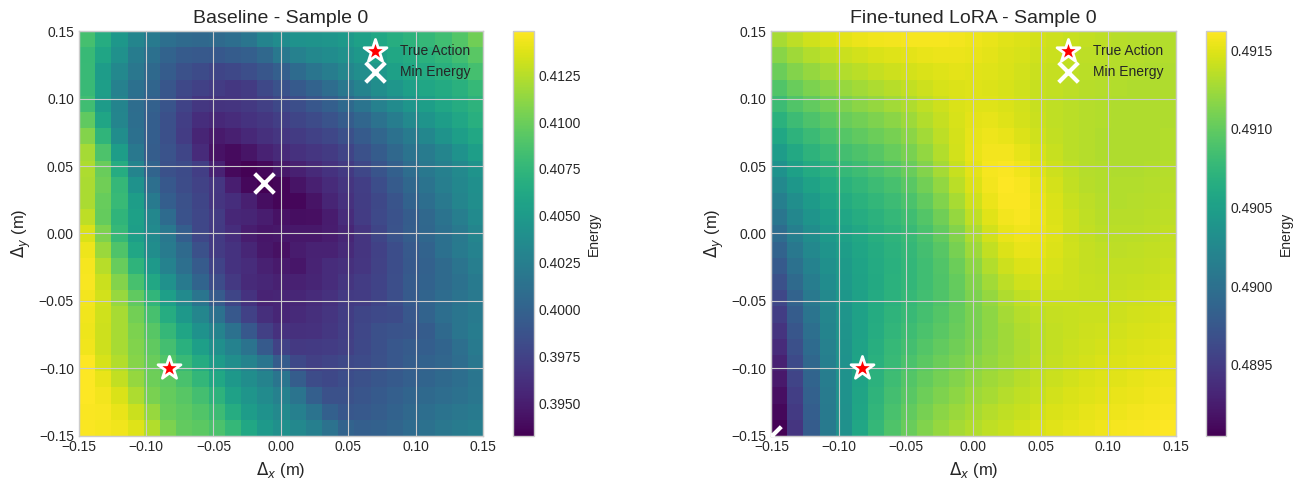

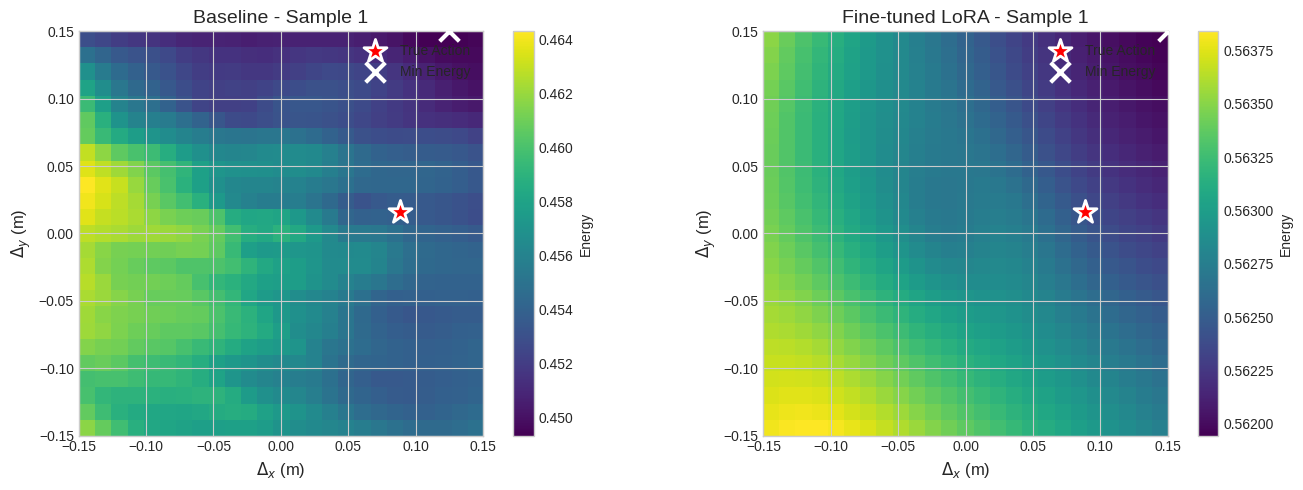

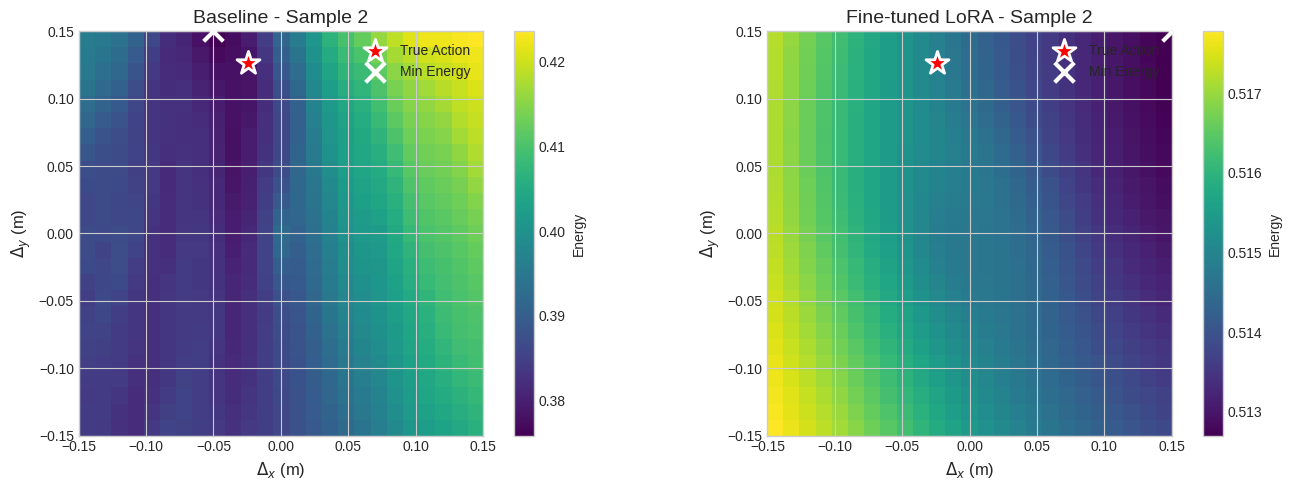

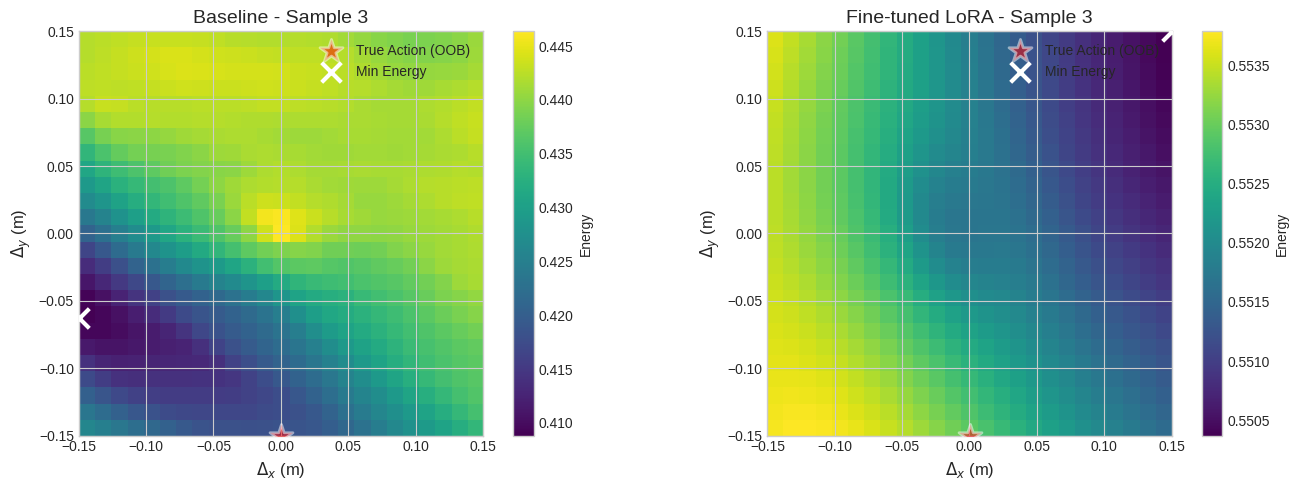

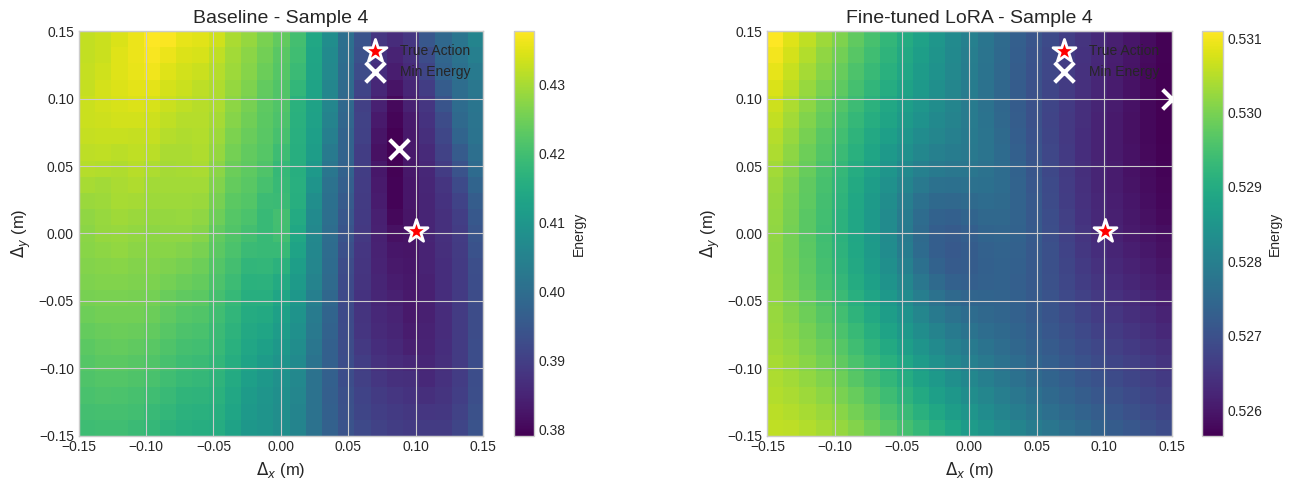

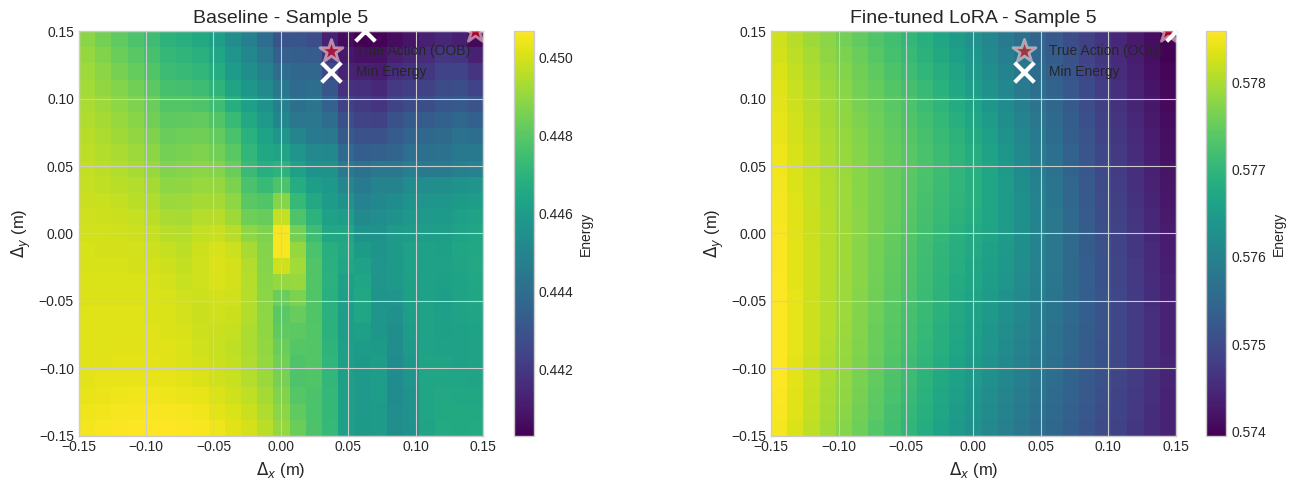

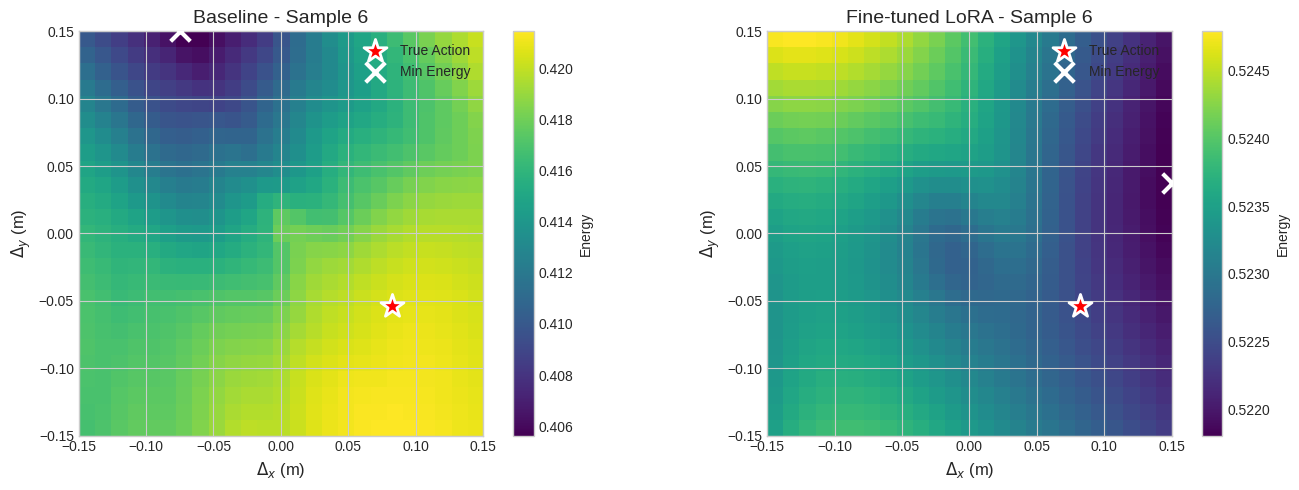

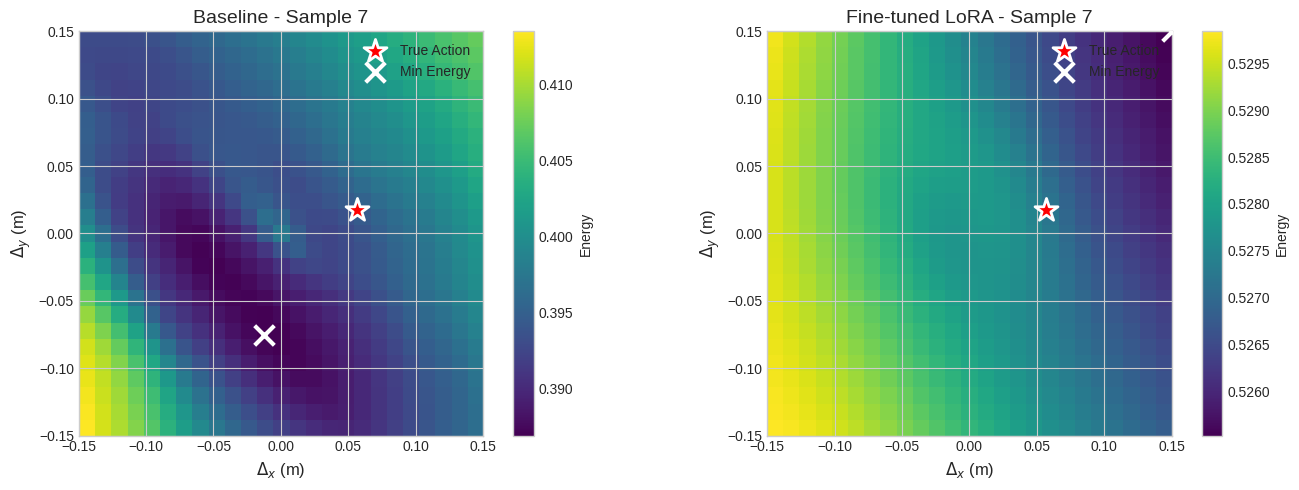

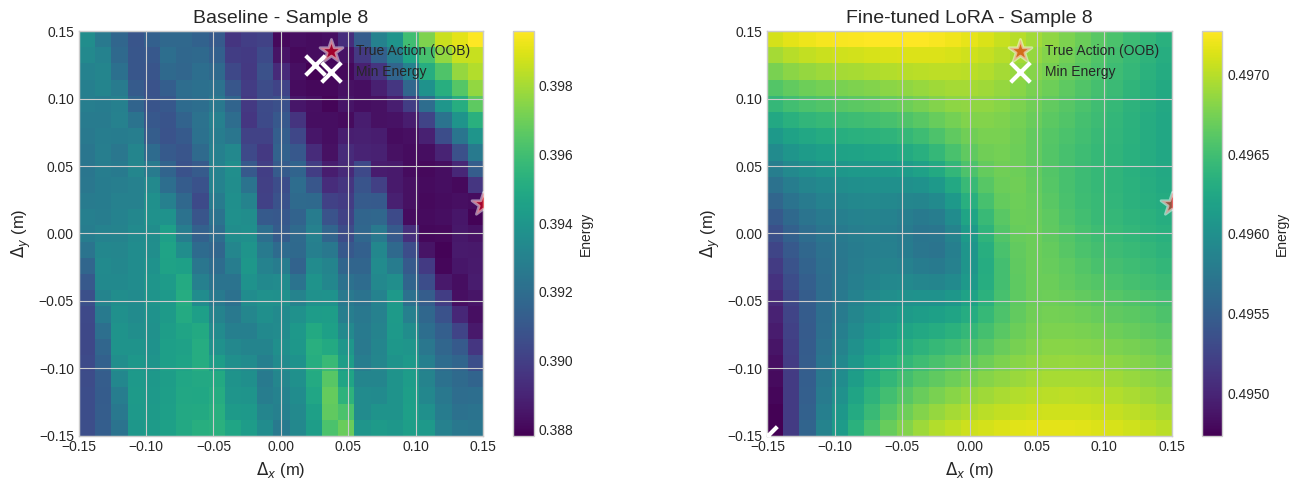

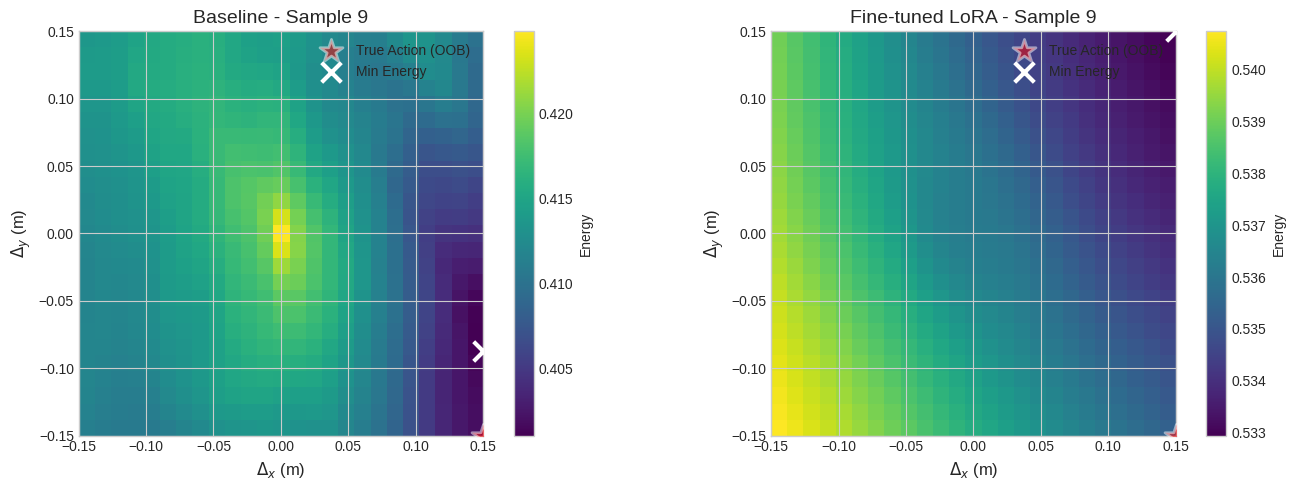

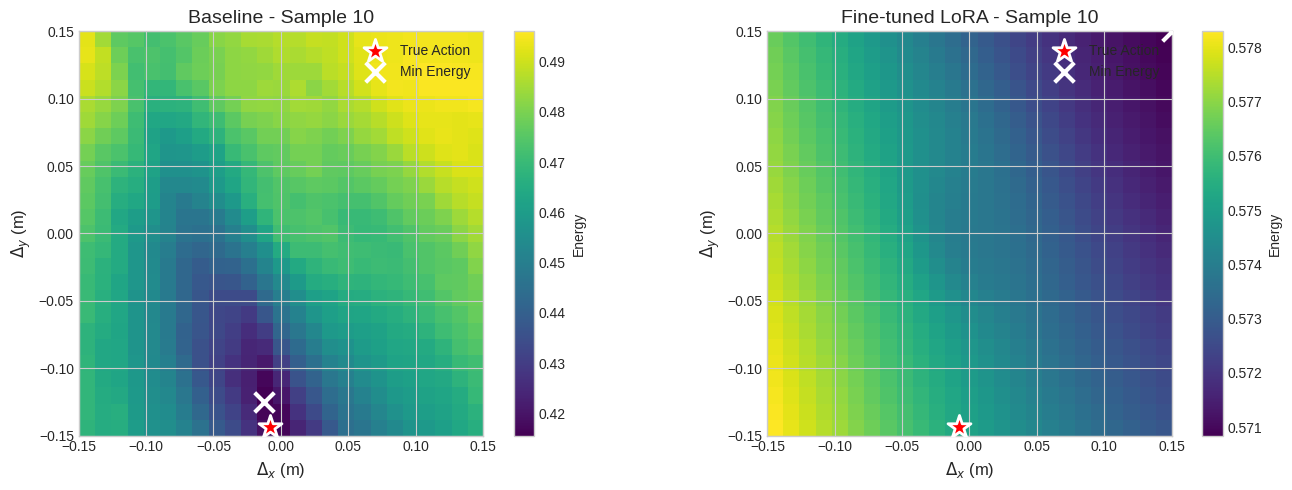

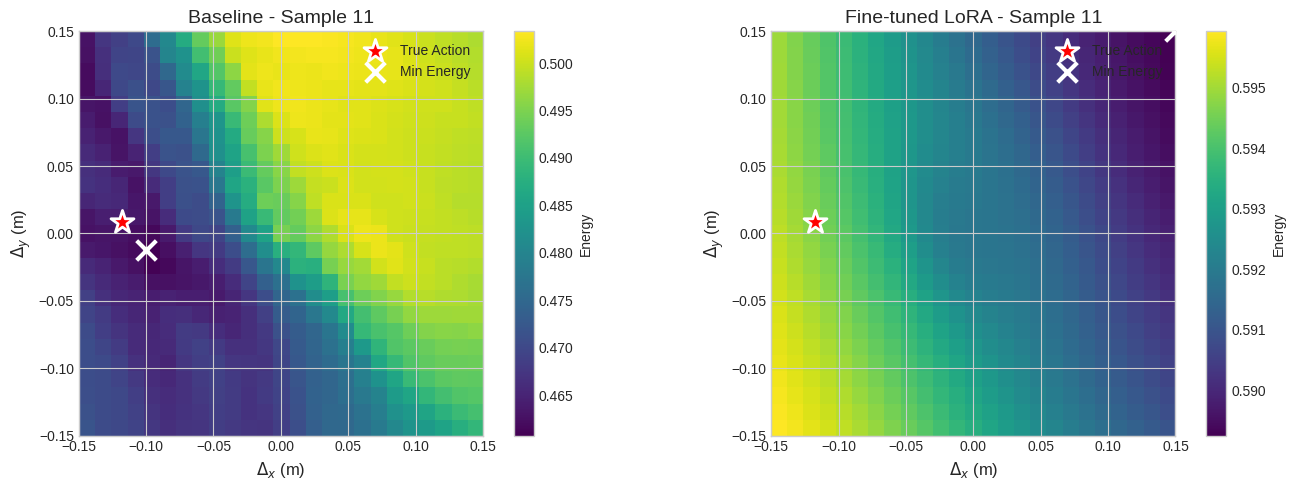

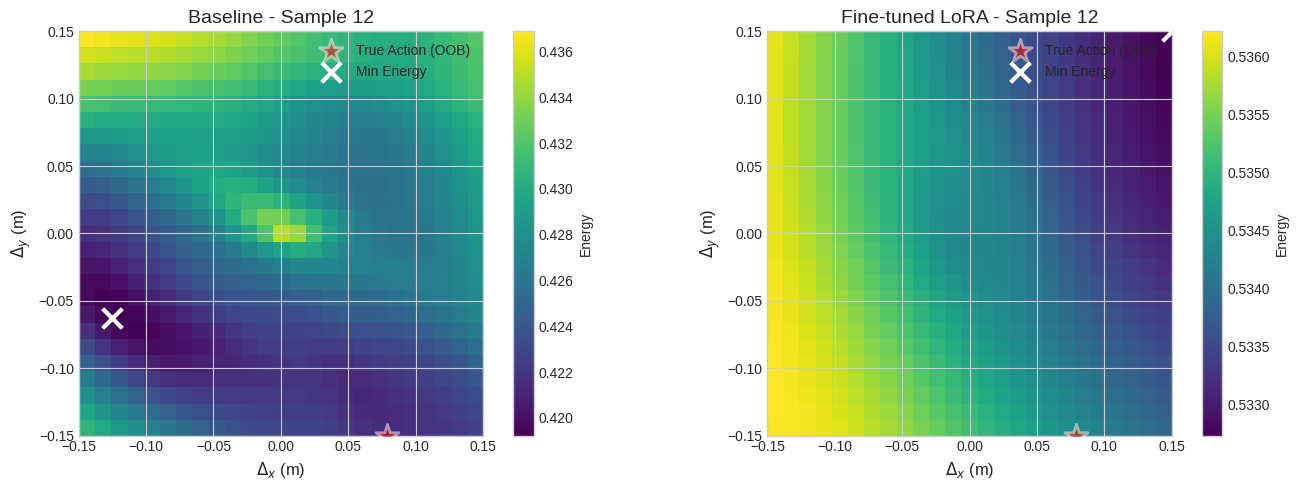

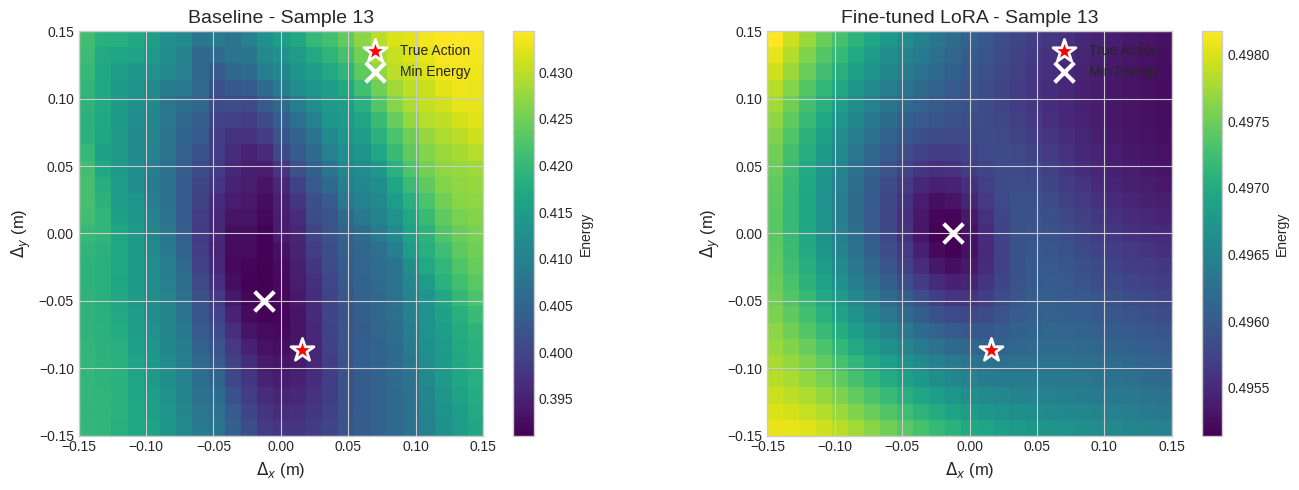

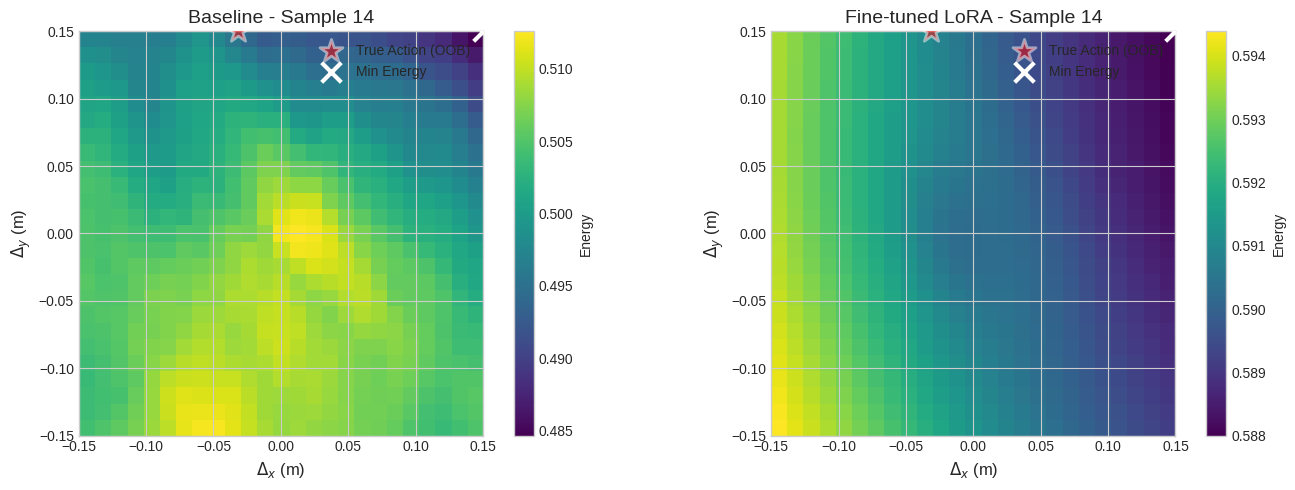

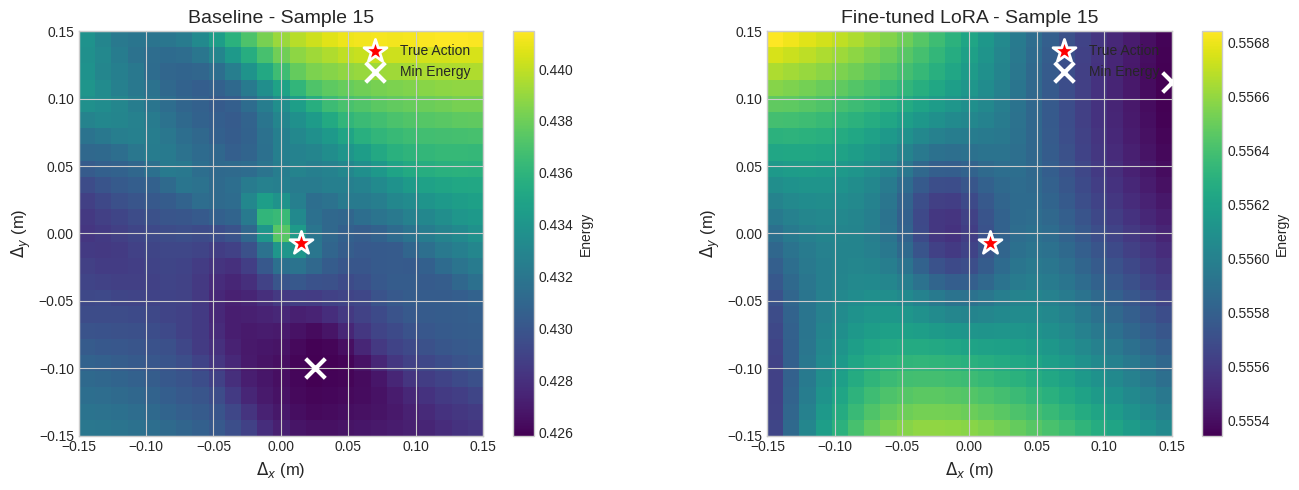

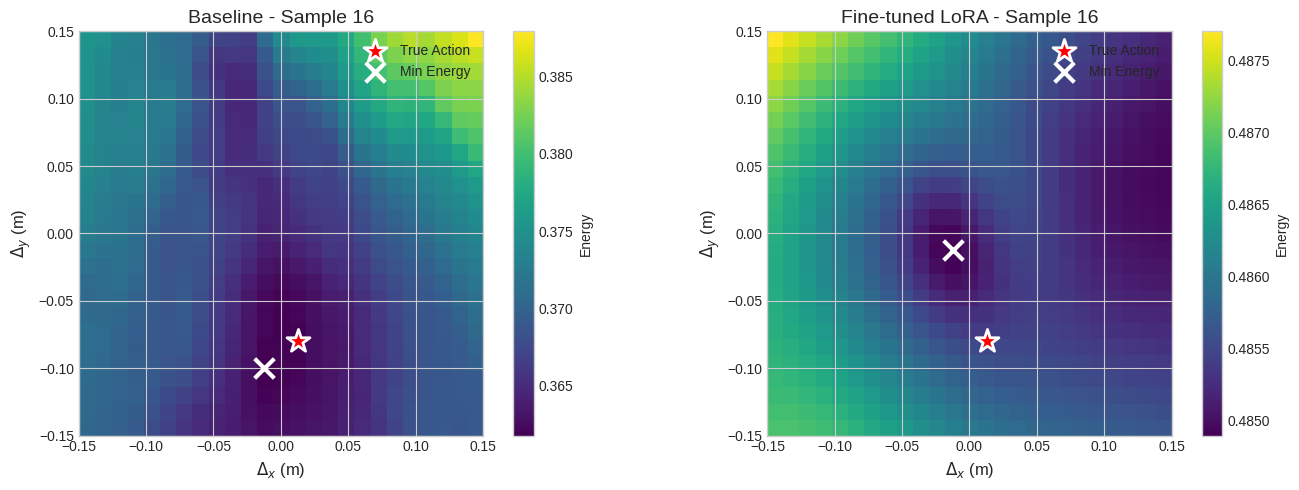

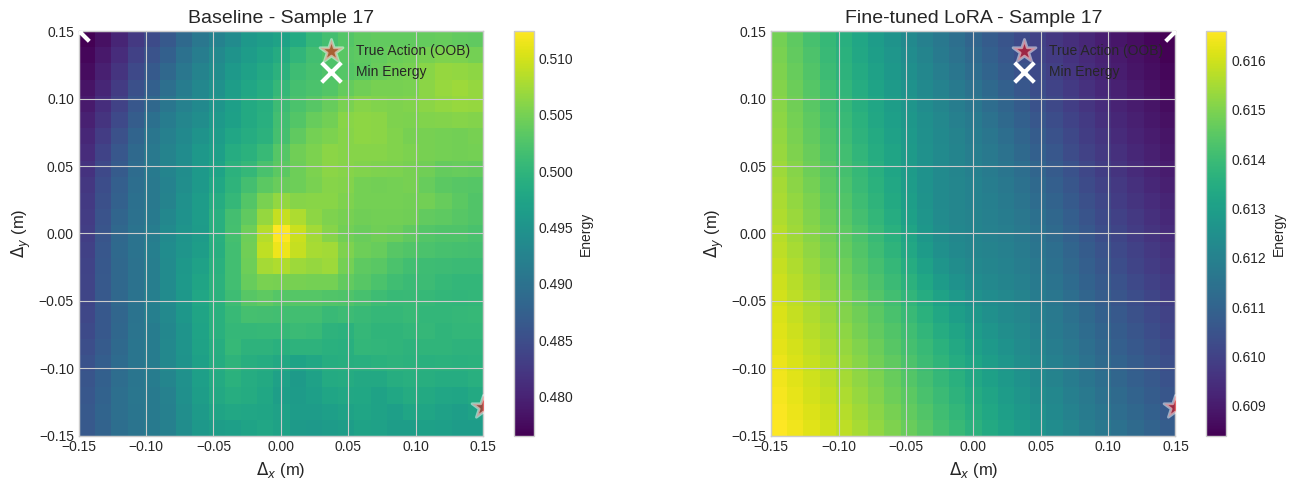

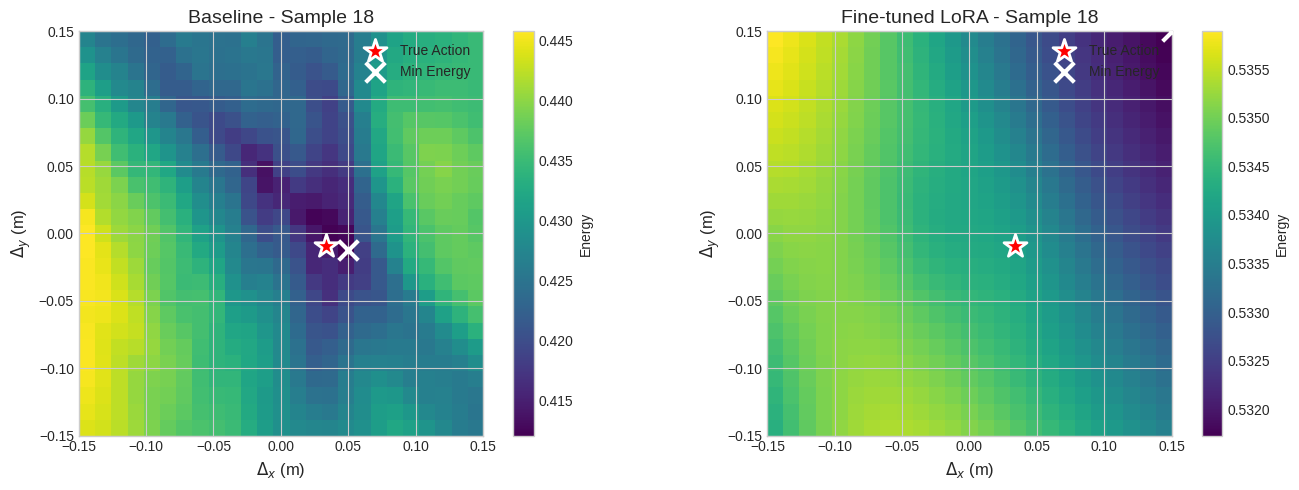

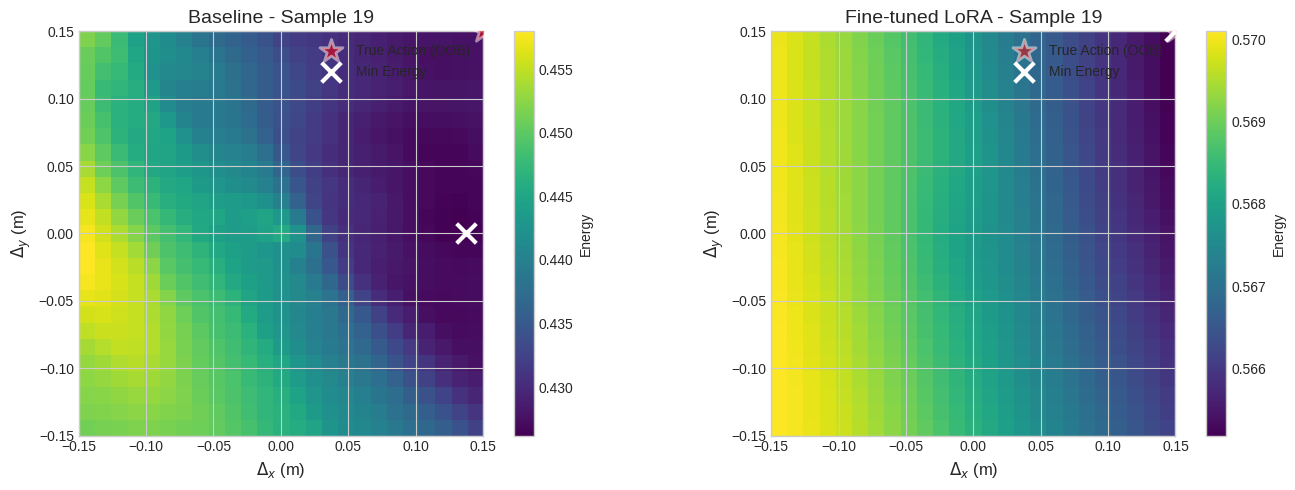

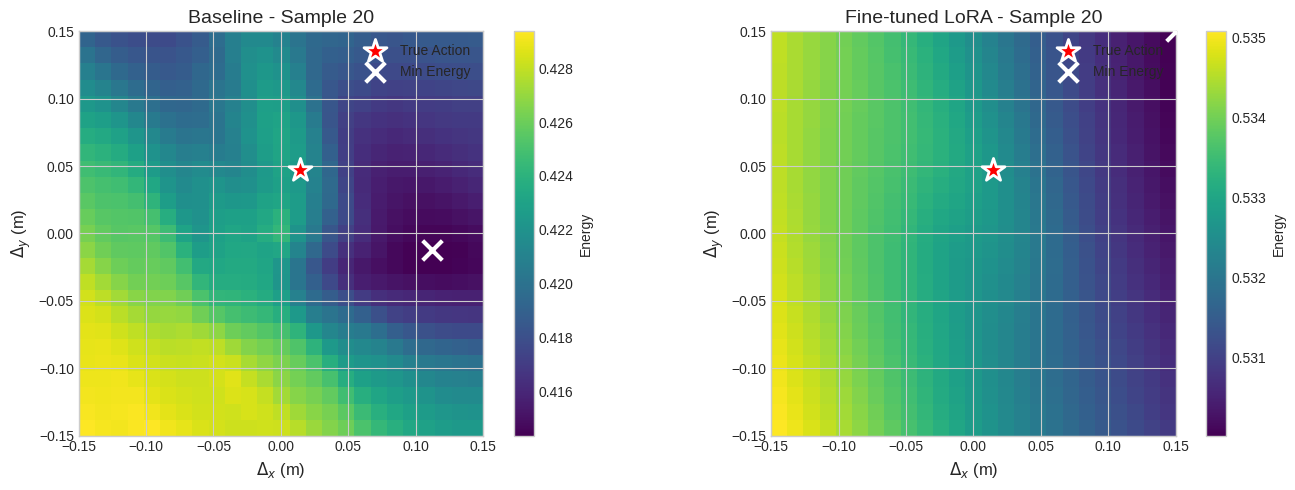

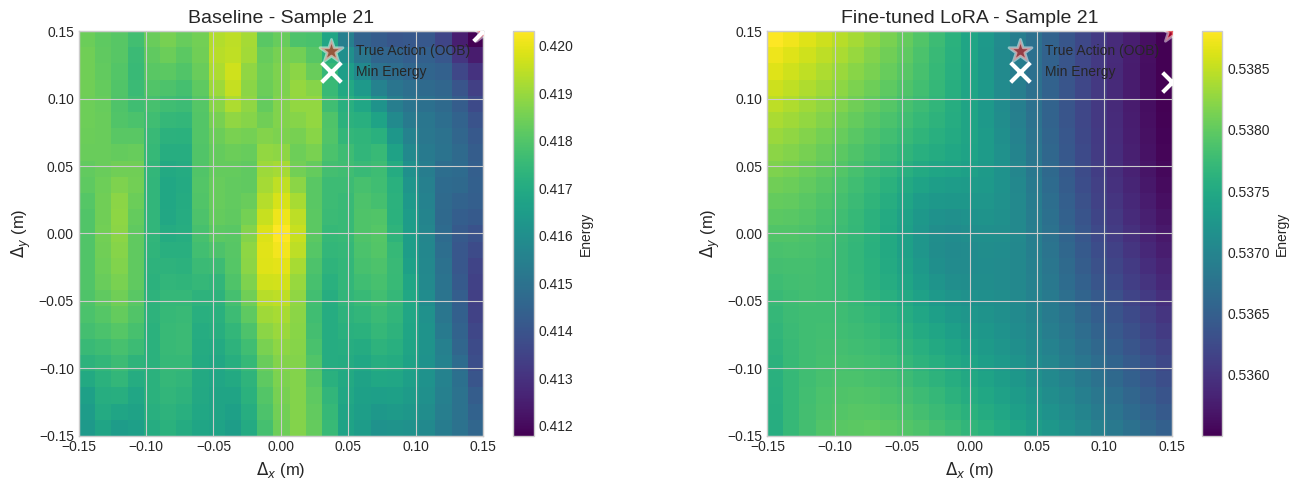

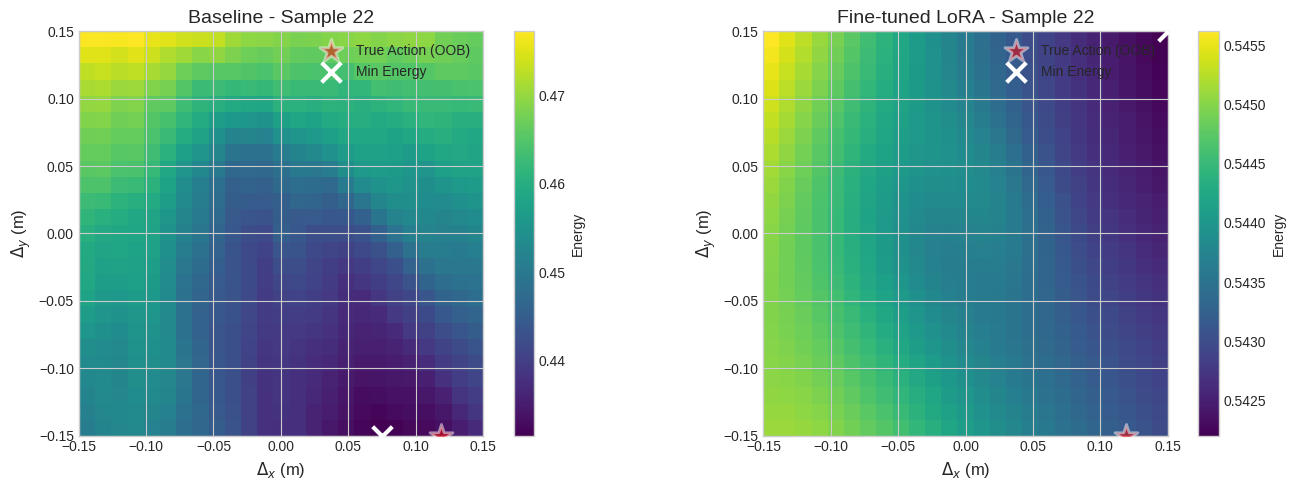

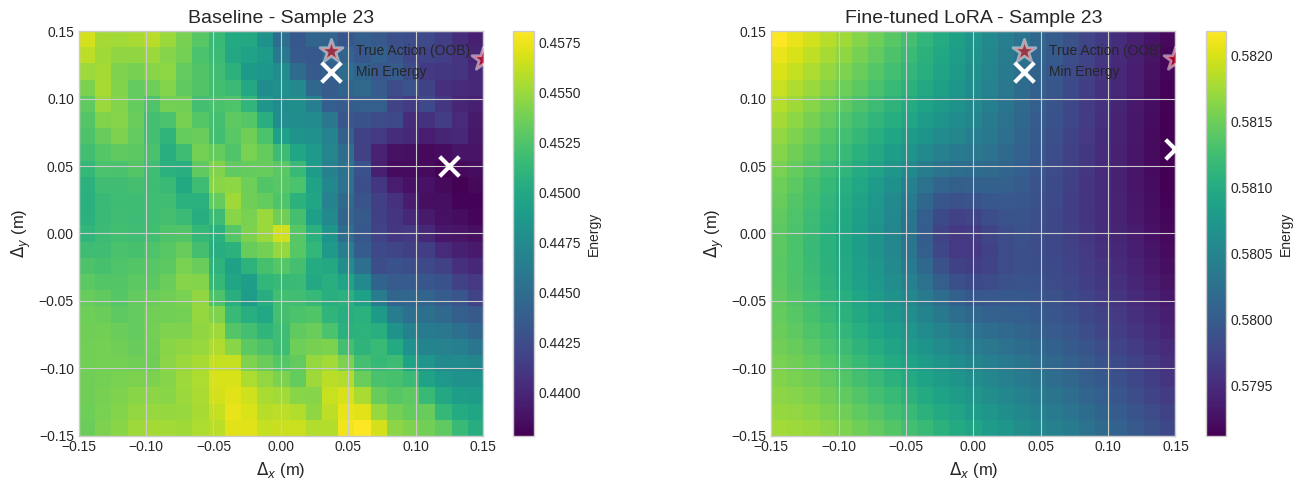

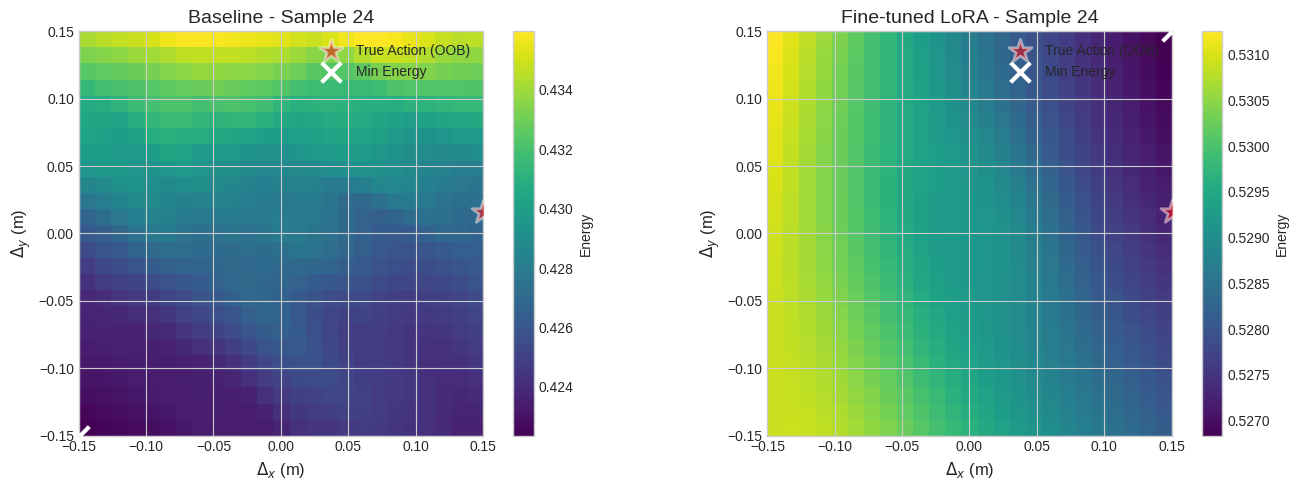

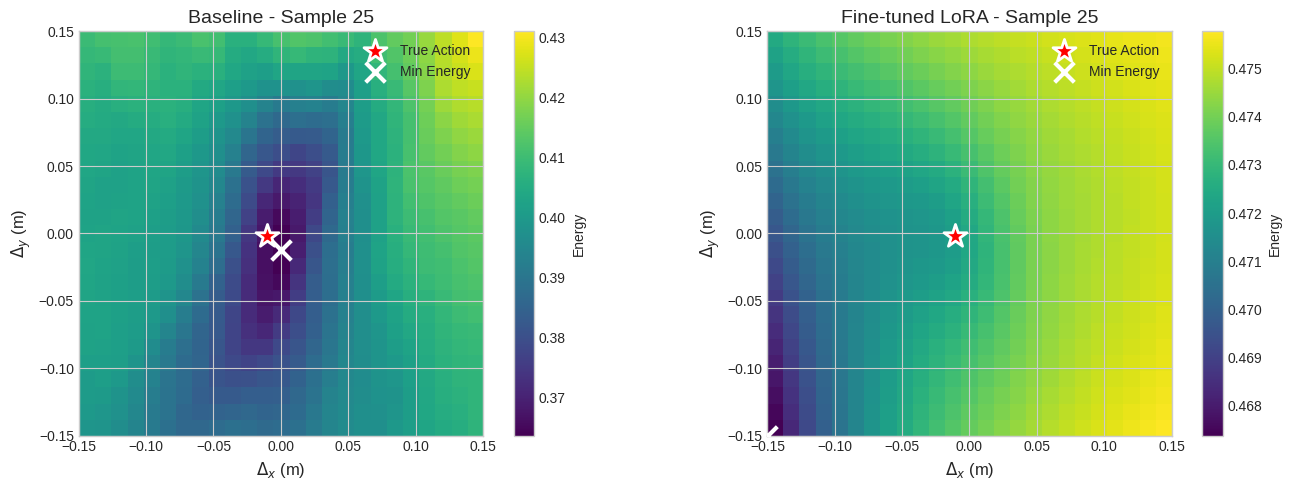

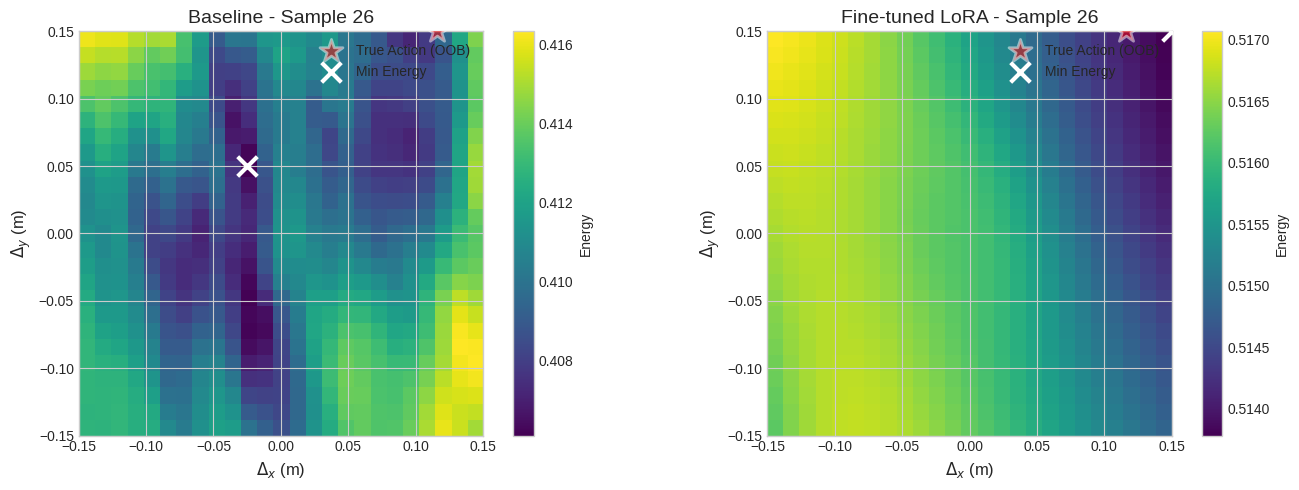

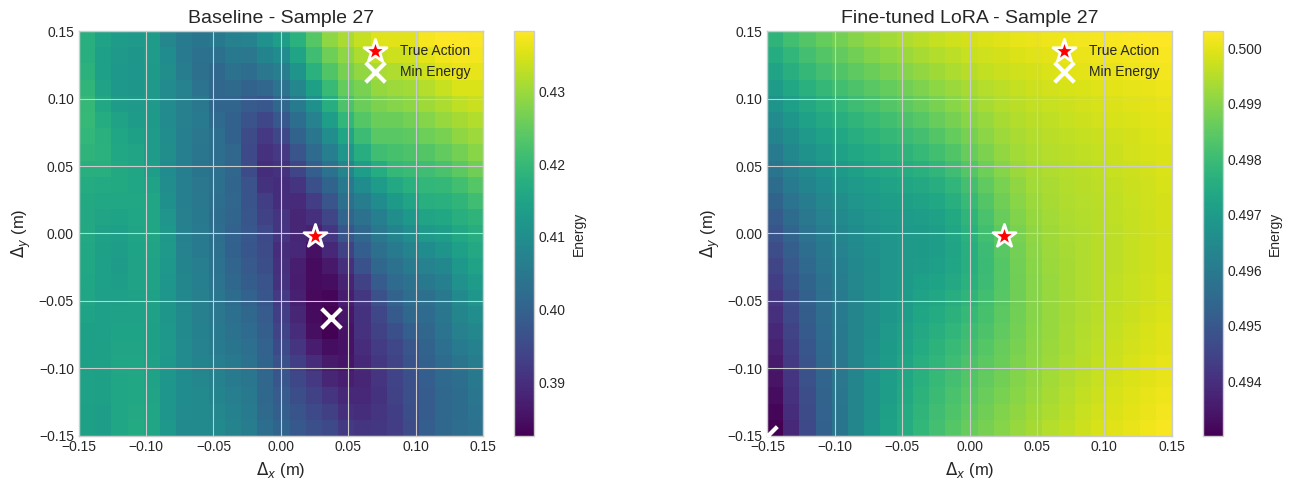

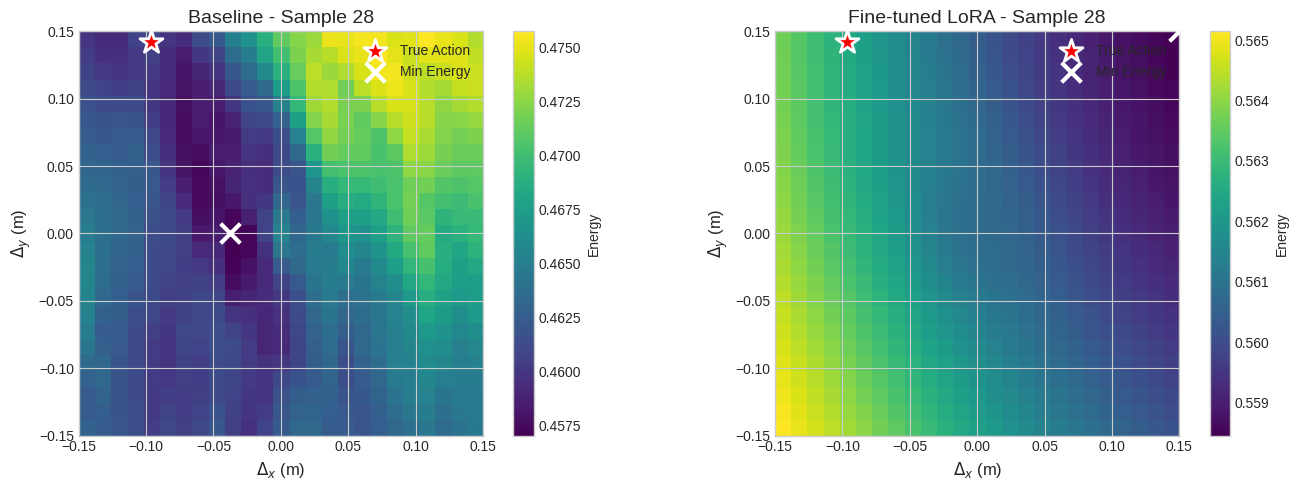

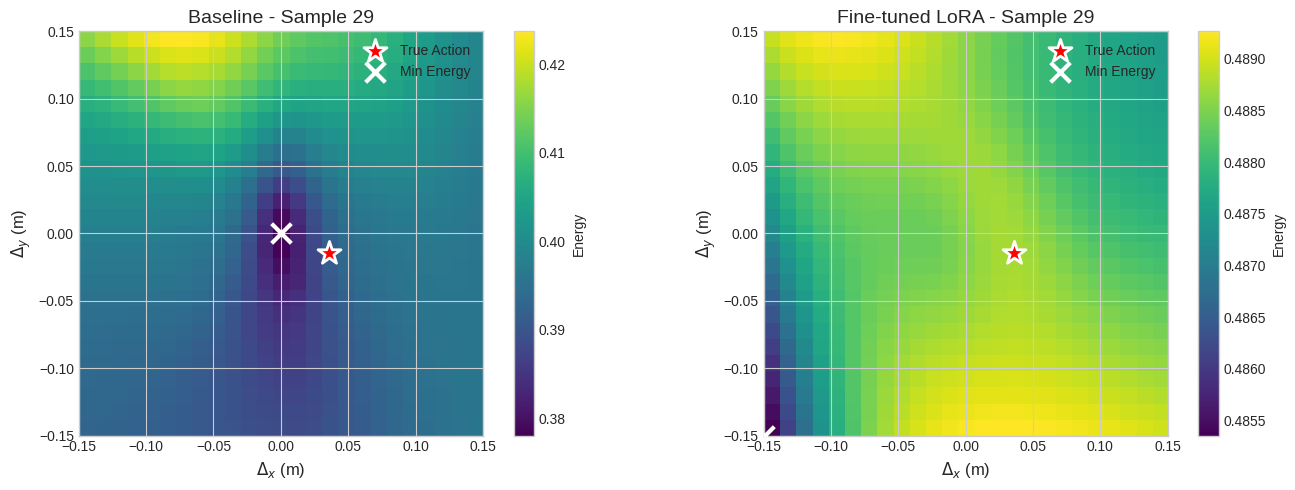

In [81]:
# Modified comparison with independent color scales

if finetuned_metrics is not None:
    comparison_df = compute_comparison(baseline_metrics, finetuned_metrics)

    print("COMPARISON: Baseline vs Fine-tuned")
    print(comparison_df.to_string(index=False))

    # Save
    comparison_df.to_csv(f"{config.output_dir}/comparison.csv", index=False)

    # Generate comparison plots with INDEPENDENT scales
    for i in range(len(trajectories)):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Plot baseline with its own scale
        plot_energy_heatmap(
            baseline_landscapes[i],
            trajectories[i][2][0, 0],
            delta_x_values,
            delta_y_values,
            title=f"Baseline - Sample {i}",
            ax=axes[0]
        )

        # Plot fine-tuned with its own scale
        plot_energy_heatmap(
            finetuned_landscapes[i],
            trajectories[i][2][0, 0],
            delta_x_values,
            delta_y_values,
            title=f"Fine-tuned LoRA - Sample {i}",
            ax=axes[1]
        )

        plt.tight_layout()
        plt.savefig(f"{config.output_dir}/comparison_sample_{i}_independent_scales.png",
                    dpi=150, bbox_inches='tight')
        plt.show()

## Cell 11: Export

In [90]:
# save
summary = {
    'config': {
        'grid_size': config.grid_size,
        'grid_resolution': config.grid_resolution,
        'num_trajectories': len(trajectories),
        'action_repeat': config.action_repeat,
        'data_source': 'DROID' if config.use_droid else 'Official Example',
    },
    'baseline': baseline_metrics.describe().to_dict() if baseline_metrics is not None else None,
    'finetuned': finetuned_metrics.describe().to_dict() if finetuned_metrics is not None else None,
}

with open(f"{config.output_dir}/summary.json", 'w') as f:
    json.dump(summary, f, indent=2, default=str)

In [93]:
!zip -r energy_analysis_results.zip energy_analysis_results/

# If you're in Google Colab, download it
from google.colab import files
files.download('energy_analysis_results.zip')

  adding: energy_analysis_results/ (stored 0%)
  adding: energy_analysis_results/comparison_sample_4_independent_scales.png (deflated 14%)
  adding: energy_analysis_results/finetuned_metrics.csv (deflated 57%)
  adding: energy_analysis_results/summary.json (deflated 73%)
  adding: energy_analysis_results/comparison_sample_3.png (deflated 19%)
  adding: energy_analysis_results/comparison_sample_15.png (deflated 20%)
  adding: energy_analysis_results/comparison_sample_1.png (deflated 21%)
  adding: energy_analysis_results/3d_comparison_sample_6.png (deflated 4%)
  adding: energy_analysis_results/comparison_sample_9.png (deflated 19%)
  adding: energy_analysis_results/sample_20_baseline_3d.png (deflated 2%)
  adding: energy_analysis_results/comparison_sample_25.png (deflated 19%)
  adding: energy_analysis_results/sample_6_finetuned_3d.png (deflated 2%)
  adding: energy_analysis_results/comparison_sample_19.png (deflated 19%)
  adding: energy_analysis_results/comparison_sample_7_independen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cell 12: 3D Energy Landscape

Saved to ./energy_analysis_results/sample_6_baseline_3d_rotated.png
Saved to ./energy_analysis_results/sample_6_finetuned_3d.png
Saved to ./energy_analysis_results/sample_20_baseline_3d.png
Saved to ./energy_analysis_results/sample_20_finetuned_3d.png


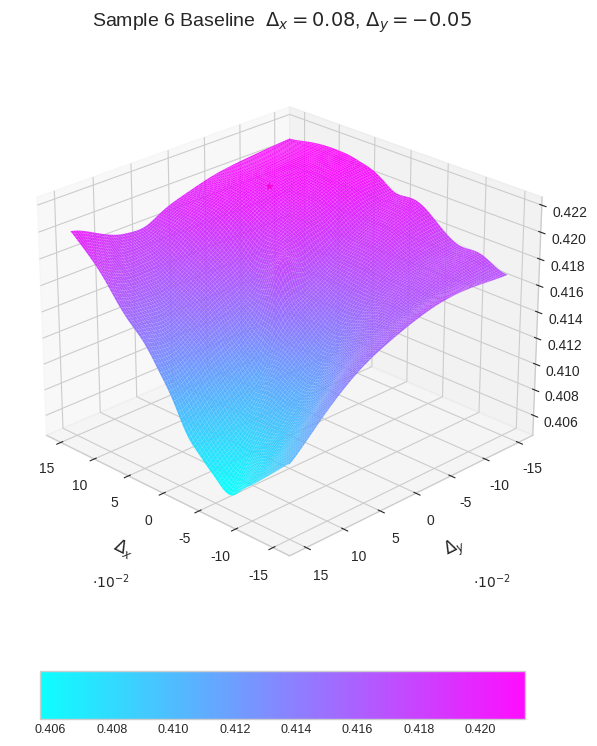

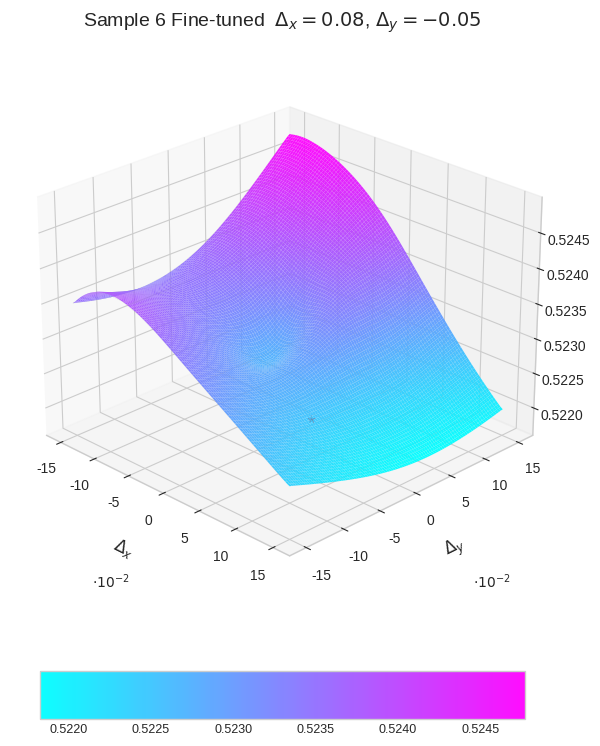

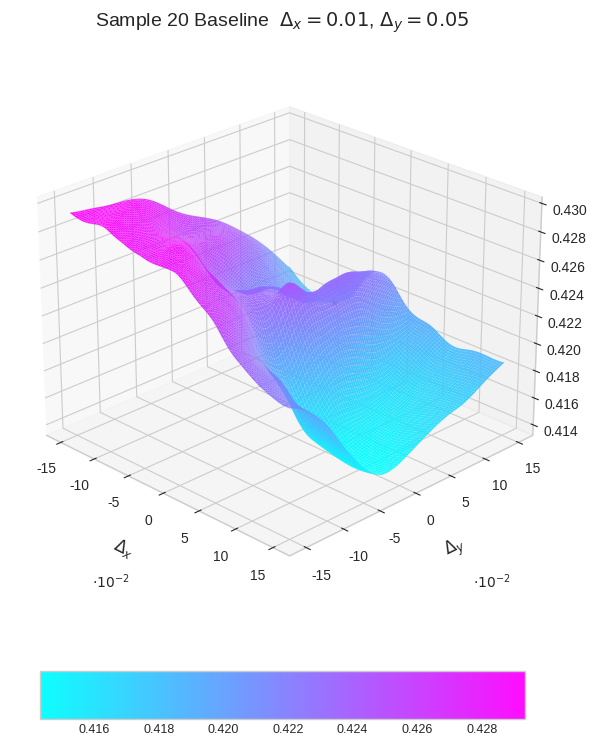

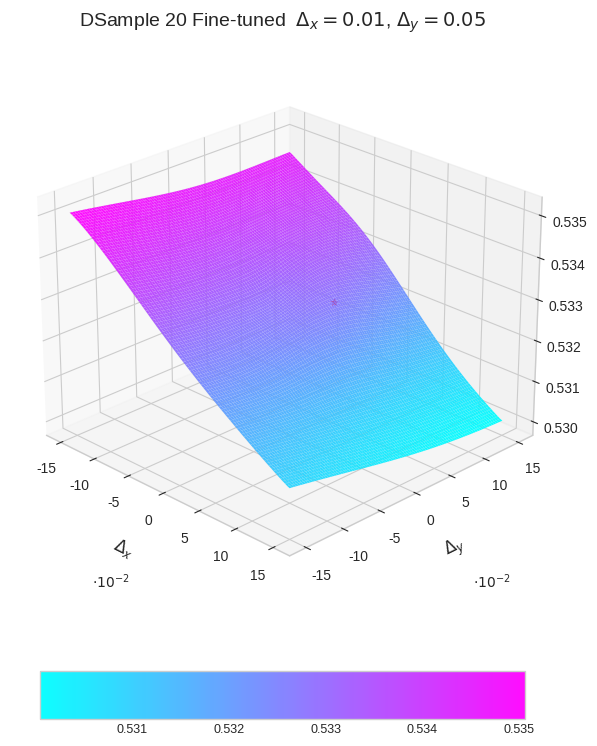

In [88]:
# Cell 6b: 3D Energy Landscape Visualization

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline

def plot_energy_landscape_3d(
    energy_landscape: np.ndarray,
    delta_x_values: np.ndarray,
    delta_y_values: np.ndarray,
    true_action: Optional[np.ndarray] = None,
    task_name: str = "DROID",
    title: Optional[str] = None,  # If None, auto-generate from true_action
    upsample_factor: int = 4,
    smooth_sigma: float = 0.8,
    elev: float = 25,
    azim: float = -45,  # Changed default to -45
    figsize: Tuple[int, int] = (10, 8),
    cmap: str = 'cool',
    show_colorbar: bool = True,
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Create a 3D surface plot of the energy landscape (V-JEPA2 paper style).

    Args:
        energy_landscape: [grid_res, grid_res] 2D energy array
        delta_x_values: 1D array of x axis values
        delta_y_values: 1D array of y axis values
        true_action: [7] ground truth action
        task_name: Name of task for auto-generated title
        title: Plot title (if None, auto-generates from true_action)
        upsample_factor: Factor to upsample grid for smoothness
        smooth_sigma: Gaussian smoothing sigma
        elev: Elevation angle for 3D view
        azim: Azimuth angle for 3D view
        figsize: Figure size
        cmap: Colormap name
        show_colorbar: Whether to show colorbar
        save_path: Path to save figure

    Returns:
        matplotlib Figure object
    """
    # Auto-generate title if not provided
    if title is None:
        if true_action is not None:
            title = f"{task_name}  $\\Delta_x = {true_action[0]:.2f}$, $\\Delta_y = {true_action[1]:.2f}$"
        else:
            title = f"{task_name} Energy Landscape"

    # Create upsampled grid for smoother surface
    if upsample_factor > 1:
        spline = RectBivariateSpline(
            delta_x_values,
            delta_y_values,
            energy_landscape
        )

        x_fine = np.linspace(delta_x_values[0], delta_x_values[-1],
                            len(delta_x_values) * upsample_factor)
        y_fine = np.linspace(delta_y_values[0], delta_y_values[-1],
                            len(delta_y_values) * upsample_factor)

        energy_smooth = spline(x_fine, y_fine)
    else:
        x_fine = delta_x_values
        y_fine = delta_y_values
        energy_smooth = energy_landscape.copy()

    # Apply gaussian smoothing
    if smooth_sigma > 0:
        energy_smooth = gaussian_filter(energy_smooth, sigma=smooth_sigma)

    # Create meshgrid
    X, Y = np.meshgrid(x_fine, y_fine, indexing='ij')

    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot surface
    surf = ax.plot_surface(
        X, Y, energy_smooth,
        cmap=cmap,
        edgecolor='none',
        alpha=0.95,
        antialiased=True,
        rcount=100,
        ccount=100
    )

    # Add wireframe for grid effect (like paper)
    ax.plot_wireframe(
        X[::upsample_factor*2, ::upsample_factor*2],
        Y[::upsample_factor*2, ::upsample_factor*2],
        energy_smooth[::upsample_factor*2, ::upsample_factor*2],
        color='black',
        alpha=0.1,
        linewidth=0.3
    )

    # Mark true action if provided
    if true_action is not None:
        gt_x, gt_y = true_action[0], true_action[1]

        # Check if within grid bounds
        if (delta_x_values[0] <= gt_x <= delta_x_values[-1] and
            delta_y_values[0] <= gt_y <= delta_y_values[-1]):

            # Get energy at true action location
            spline_point = RectBivariateSpline(
                delta_x_values, delta_y_values, energy_landscape
            )
            gt_energy = spline_point(gt_x, gt_y)[0, 0]

            # Plot marker
            ax.scatter([gt_x], [gt_y], [gt_energy],
                      color='red', s=100, marker='*',
                      edgecolors='white', linewidths=1,
                      label='True Action', zorder=10)

    # Axis labels
    ax.set_xlabel(r'$\Delta_x$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$\Delta_y$', fontsize=12, labelpad=10)
    ax.set_zlabel('Energy', fontsize=12, labelpad=10)

    # Format axis ticks to show ·10⁻² style
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.0f}'))

    # Add ·10⁻² annotation
    ax.text2D(0.15, 0.02, r'$\cdot 10^{-2}$', transform=ax.transAxes, fontsize=10)
    ax.text2D(0.85, 0.02, r'$\cdot 10^{-2}$', transform=ax.transAxes, fontsize=10)

    # Set view angle
    ax.view_init(elev=elev, azim=azim)

    # Title
    ax.set_title(title, fontsize=14, pad=20)

    # Colorbar
    if show_colorbar:
        cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10,
                           orientation='horizontal', pad=0.1)
        cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"Saved to {save_path}")

    return fig


# Sample 6 - Baseline
fig = plot_energy_landscape_3d(
    energy_landscape=baseline_landscapes[6],
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    true_action=trajectories[6][2][0, 0],
    task_name="Sample 6 Baseline",
    azim=135,
    save_path=f"{config.output_dir}/sample_6_baseline_3d_rotated.png"
)

# Sample 6 - Fine-tuned
fig = plot_energy_landscape_3d(
    energy_landscape=finetuned_landscapes[6],
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    true_action=trajectories[6][2][0, 0],
    task_name="Sample 6 Fine-tuned",
    save_path=f"{config.output_dir}/sample_6_finetuned_3d.png"
)

# Sample 20 - Baseline
fig = plot_energy_landscape_3d(
    energy_landscape=baseline_landscapes[20],
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    true_action=trajectories[20][2][0, 0],
    task_name="Sample 20 Baseline",
    save_path=f"{config.output_dir}/sample_20_baseline_3d.png"
)

# Sample 20 - Fine-tuned
fig = plot_energy_landscape_3d(
    energy_landscape=finetuned_landscapes[20],
    delta_x_values=delta_x_values,
    delta_y_values=delta_y_values,
    true_action=trajectories[20][2][0, 0],
    task_name="DSample 20 Fine-tuned",
    save_path=f"{config.output_dir}/sample_20_finetuned_3d.png"
)


